### In this notebook I will be implementing the closed form, gradient descent and stochastic gradient descent techniques and also evaluating their performance through various combinations of learning rates and regularization parameters on the training, convergence, and the ultimate performance

### Steps taken:

1. The constructor initializes the class with input features 𝑋, target variable 𝑦, learning rate, epsilon for convergence, maximum iterations, regularization parameter (𝜆) , and flags for gradient descent (gd) and stochastic gradient descent (sgd)
2. The split_data method splits the dataset into training and test setts
3. Normalization methods normalize_train and normalize_test standardize the features and add a column of ones for the intercept term
4. rank, check_fullRank, check_lowRank methods check if the matrix X has full rank or is low rank
5. The close_form_solution method calculates the optimal weights using the normal equation
6. The gradient_descent method iteratively updates the weights to minimize the cost function
7. The stochastic_gd method updates weights using a single training example at a time
8. The fit method orchestrates the data preparation, rank checking, and calls the appropriate solution method (closed-form or gradient descent
9. The plot_rmse method plots the RMSE over iterations for gradient descent methods


In [1]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class LinearRegression:

    def __init__(self, X, y, learning_rate, epsilon, max_iteration, reg_lambda = 0, gd = False, sgd = False):

        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iteration = max_iteration
        self.reg_lambda = reg_lambda
        self.gd = gd
        self.sgd = sgd

    def split_data(self):
        X_train, X_test , y_train, y_test = train_test_split(self.X, self.y, test_size = 0.3, shuffle = True, random_state = 42)

        return X_train, X_test , y_train, y_test

    def add_X0(self, X):
        return np.column_stack([np.ones([X.shape[0],1]), X])

    def normalize_train(self,X):
        mean = np.mean(X, axis = 0)
        std = np.std(X, axis = 0)
        X = (X - mean)/ std
        X = self.add_X0(X)
        return X, mean, std

    def normalize_test(self, X, mean, std):
        X = (X - mean)/ std
        X = self.add_X0(X)
        return X

    ## add ones after normalizing

    def rank(self, X):
        u,s,v = np.linalg.svd(X)
        #print(s)
        return len([x for x in s if x>0.0005])

        # or np.linalg.matrix_rank

    def check_fullRank(self, X):
        rank = self.rank(X)
        if rank == min(X.shape):
            self.fullRank = True
            print("X is Full rank")
        else:
            self.fullRank = False
            print("X is not Full rank")


    def check_lowRank(self, X):
        if X.shape[0]<X.shape[1]:
            self.low_rank = True
            print("X is low rank")
        else:
            self.low_rank = False
            print("X is not low rank")

    def close_form_solution(self, X, y):
        identity_mat = np.identity(X.shape[1])
        self.theta = np.linalg.inv(X.T.dot(X) + self.reg_lambda * identity_mat).dot(X.T).dot(y)
        print("\n Closed form solution is as follows")
        #print("following closed form solution")
        #return theta

    def predict(self, X):
        return X.dot(self.theta)


    def sse(self, X, y):
        y_hat = self.predict(X)
        ## loss function
        return ((y_hat - y) ** 2).sum()

    def cost_function(self, X, y):
        # Our cost function is RMSE
        y_hat = self.predict(X)
        rmse = np.sqrt(self.sse(X,y) / X.shape[0])        
        return rmse

    def cost_derivative(self, X, y):
        # The derivative will be based on RMSE only
        y_hat = self.predict(X)
        #print(y_hat,y,X.shape[0])
        return ((y_hat - y).dot(X)) / X.shape[0]
        

    def gradient_descent(self, X, y):
        errors = []
        prev_error = float('inf')
        self.theta = np.zeros(X.shape[1])

        for i in tqdm(range(self.max_iteration),colour = 'red'):
            self.theta -= self.learning_rate * (self.cost_derivative(X,y) + self.reg_lambda * self.theta)
            error = self.cost_function(X,y)
            errors.append(error)
            #print("previous err:", prev_error)
            if abs(error - prev_error)<self.epsilon:
                print("Model stopped learning")
                break
            prev_error = error
        #print("following gd")
        self.plot_rmse(errors)
        #print(errors)
        
    def stochastic_gd(self, X, y):
        print("SGD")
        errors = []
        prev_error = float('inf')
        self.theta = np.zeros(X.shape[1])

        for i in tqdm(range(self.max_iteration), colour='red'):
            for j in range(X.shape[0]):
                random_index = np.random.randint(0, X.shape[0])
                x_i = X[random_index:random_index+1]
                y_i = y[random_index:random_index+1]
                #print(x_i,y_i)
                # Update the parameters using the cost_derivative function
                self.theta -= self.learning_rate * (self.cost_derivative(x_i, y_i) + self.reg_lambda * self.theta)

            error = self.cost_function(X, y)
            errors.append(error)

            if abs(error - prev_error) < self.epsilon:
                print("Model stopped learning")
                break

            prev_error = error

        self.plot_rmse(errors)
        
        
    def fit(self):
        X_train, X_test , y_train, y_test = self.split_data()
        X_train, mean, std = self.normalize_train(X_train)
        X_test = self.normalize_test(X_test, mean, std)
        self.check_fullRank(X_train)
        self.check_lowRank(X_train)

        if self.fullRank and not self.low_rank and X_train.shape[1]<1000 and not self.gd and not self.sgd:
            self.close_form_solution(X_train, y_train)
        elif self.gd and not self.sgd:
            #self.theta = np.ones(X_train.shape[1])
            self.gradient_descent(X_train, y_train)
        elif self.sgd and not self.gd:
            self.stochastic_gd(X_train, y_train)
            
            
        best_theta = self.theta
        
        train_sse = self.sse(X_train, y_train)
        train_rmse = self.cost_function(X_train, y_train)
        
        test_sse = self.sse(X_test, y_test)
        test_rmse = self.cost_function(X_test, y_test)
        
        print(f"\nWeights/Theta's:\n{self.theta}\n")
        print(f"Train data:\nSSE: {train_sse} \nRMSE: {train_rmse}")
        print(f"\nTest data:\nSSE: {test_sse} \nRMSE: {test_rmse}")
        
        return train_rmse, test_rmse


    def plot_rmse(self, error_sequence):
        # Data for plotting
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='iterations', ylabel='RMSE')  # Update this line
        
        ax.grid()
        plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)

        plt.show()



# Loading dataset

In [3]:
df1 = pd.read_csv("housing.csv", header = None)
X_h = df1.values[:,:-1]
y_h = df1.values[:, -1]

df2 = pd.read_csv("yachtData.csv", header = None)
X_y = df2.values[:,:-1]
y_y = df2.values[:, -1]

df3 = pd.read_csv("concreteData.csv", header = None)
X_c = df3.values[:,:-1]
y_c = df3.values[:, -1]

In [7]:
# h_lr = 0.0004
# h_tol = 0.005

# y_lr = 0.001
# y_tol = 0.001

# c_lr = 0.0007
# c_tol = 0.0001

In [8]:
# Create an initial DataFrame
results_df = pd.DataFrame(columns=['Dataset','GD', 'SGD', 'Reg Lambda', 'Learning Rate', 'Tolerance', 'Max Iteration',  'Train RMSE', 'Test RMSE'])

# Sample function to add a new row to the DataFrame
def add_result(results_df, dataset_name, params, train_rmse, test_rmse):
    new_row = {
        'Dataset': dataset_name,
        'GD': params['gd'],
        'SGD': params['sgd'],
        'Reg Lambda': params['reg_lambda'],
        'Learning Rate': params['learning_rate'],
        'Tolerance': params['epsilon'],
        'Max Iteration': params['max_iteration'],
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse
    }
    results_df = results_df.append(new_row, ignore_index=True)
    return results_df

## Dataset 1: Housing.csv

### 1.1 Building Closed form solution without regularization parameter

In [9]:
params = {
    'gd': False,
    'sgd': False,
    'learning_rate': 0.0004,
    'epsilon': 0.005,
    'max_iteration': 50000,
    'reg_lambda': 0, 
}

closedform_housing = LinearRegression(X_h, y_h, **params)
train_rmse, test_rmse = closedform_housing.fit()

results_df = add_result(results_df, 'Housing', params, train_rmse, test_rmse)

X is Full rank
X is not low rank

 Closed form solution is as follows

Weights/Theta's:
[23.01581921 -1.10834243  0.80844562  0.34314556  0.81386437 -1.7980284
  2.91385718 -0.29892637 -2.94248735  2.09420527 -1.44708859 -2.05231744
  1.02375226 -3.88579577]

Train data:
SSE: 7981.110101579311 
RMSE: 4.74821111172655

Test data:
SSE: 3270.65230590965 
RMSE: 4.638690481265649


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)


### 1.2 Building Closed form solution with regularization parameter

In [11]:
params = {
    'gd': False,
    'sgd': False,
    'learning_rate': 0.0004,
    'epsilon': 0.005,
    'max_iteration': 50000,
    'reg_lambda': 0.01, 
}

closedform_housing_l2 = LinearRegression(X_h, y_h, **params)
train_rmse, test_rmse = closedform_housing_l2.fit()

results_df = add_result(results_df, 'Housing', params, train_rmse, test_rmse)

X is Full rank
X is not low rank

 Closed form solution is as follows

Weights/Theta's:
[23.01516906 -1.10821466  0.80823596  0.34284343  0.81392221 -1.79765557
  2.9139209  -0.29895471 -2.94207871  2.09335765 -1.44634434 -2.05220326
  1.02372405 -3.88564808]

Train data:
SSE: 7981.110308549074 
RMSE: 4.74821117329293

Test data:
SSE: 3270.715233131479 
RMSE: 4.638735105162289


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


### 1.3 Building Gradient descent without regularization parameter

X is Full rank
X is not low rank


  3%|██▏                                                                       | 1444/50000 [00:00<00:02, 23669.50it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


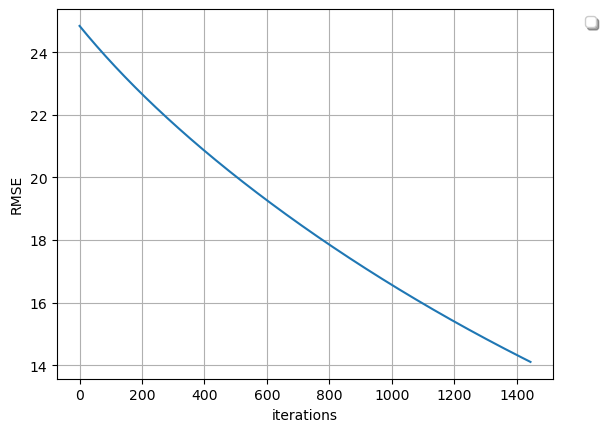


Weights/Theta's:
[10.10499378 -0.60957854  0.37665222 -0.55857243  0.80043353 -0.43443202
  2.01096895 -0.32789343 -0.23009168 -0.31943413 -0.54453852 -1.15886011
  0.62254392 -1.89709787]

Train data:
SSE: 70441.65563213793 
RMSE: 14.10630099545593

Test data:
SSE: 27531.7791863893 
RMSE: 13.45845928129388


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [12]:
params = {
    'gd': True,
    'sgd': False,
    'learning_rate': 0.0004,
    'epsilon': 0.005,
    'max_iteration': 50000,
    'reg_lambda': 0, 
}

gd_housing = LinearRegression(X_h, y_h, **params)
train_rmse, test_rmse = gd_housing.fit()

results_df = add_result(results_df, 'Housing', params, train_rmse, test_rmse)

**Note**: We are given to use Learning rate as 0.0004 but as shown above it is giving high than expected (observed from Closed form solution). Hence, we also tried to vary the learning rate and increased it to 0.04 to see the impact

#### 1.3.1 Building Gradient descent without regularization parameter and varying learning rate

X is Full rank
X is not low rank


  0%|▏                                                                           | 87/50000 [00:00<00:03, 15357.93it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


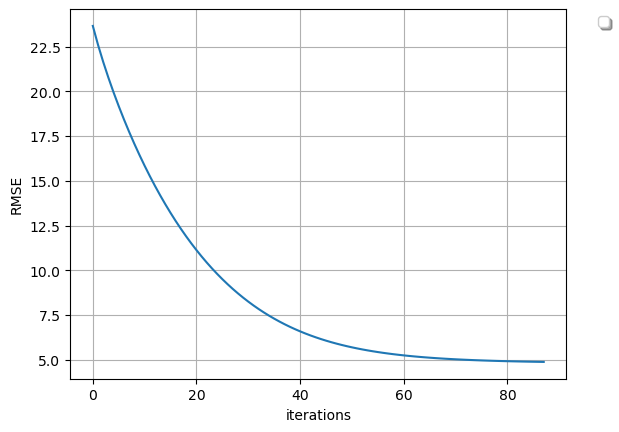


Weights/Theta's:
[22.38210281 -0.78471984  0.30086482 -0.21072491  1.00731896 -0.65826628
  3.30083262 -0.28733574 -1.70857798  0.50057139 -0.26617887 -1.77772965
  0.98012598 -3.54830353]

Train data:
SSE: 8429.723774935424 
RMSE: 4.879833913694329

Test data:
SSE: 3636.4116791567394 
RMSE: 4.8911921907735145


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [13]:
params = {
    'gd': True,
    'sgd': False,
    'learning_rate': 0.04,
    'epsilon': 0.005,
    'max_iteration': 50000,
    'reg_lambda': 0, 
}

gd_housing1 = LinearRegression(X_h, y_h, **params)
train_rmse, test_rmse = gd_housing1.fit()

results_df = add_result(results_df, 'Housing', params, train_rmse, test_rmse)

**Note**: As we can observe above, increasing the learning rate, helps us reach an optimized value of RMSE and comparing the theta's from closed form, they are also comparable.It may be possible that small value of learning rate may not have been able to reach the optimal point.

### 1.4 Building Gradient descent with regularization parameter


X is Full rank
X is not low rank


  3%|██▏                                                                       | 1438/50000 [00:00<00:01, 29458.30it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


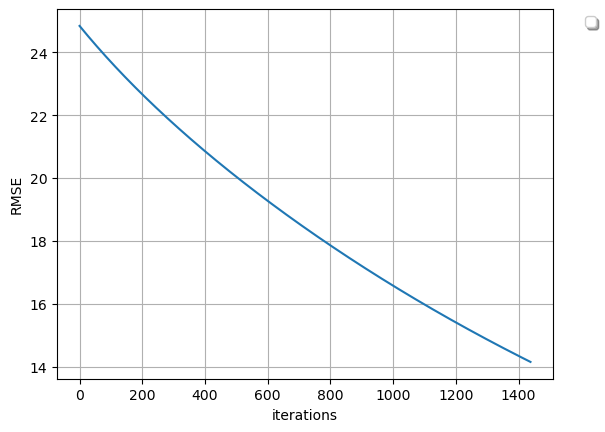


Weights/Theta's:
[10.06086804 -0.60867995  0.3767543  -0.55859495  0.79755509 -0.43460948
  2.00405074 -0.32834157 -0.22683036 -0.32046653 -0.54462671 -1.15556625
  0.62111493 -1.89099033]

Train data:
SSE: 70869.40516720724 
RMSE: 14.149065686269562

Test data:
SSE: 27690.881860420384 
RMSE: 13.497290629784592


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [15]:
params = {
    'gd': True,
    'sgd': False,
    'learning_rate': 0.0004,
    'epsilon': 0.005,
    'max_iteration': 50000,
    'reg_lambda': 0.005, 
}

gd_housing_l2 = LinearRegression(X_h, y_h, **params)
train_rmse, test_rmse = gd_housing_l2.fit()

results_df = add_result(results_df, 'Housing', params, train_rmse, test_rmse)

#### 1.4.1 Building Gradient descent with regularization parameter with optimized value of learning parameter


X is Full rank
X is not low rank


  0%|▏                                                                           | 88/50000 [00:00<00:02, 17122.78it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


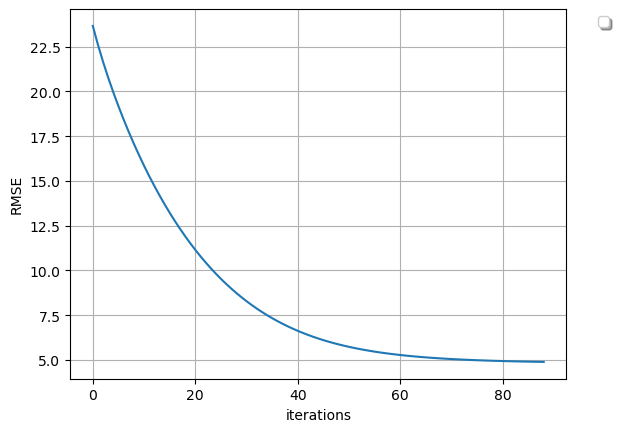


Weights/Theta's:
[22.30709337 -0.78453431  0.30229496 -0.21105001  1.00389629 -0.66071762
  3.28985088 -0.28844601 -1.70504514  0.49927663 -0.26804418 -1.77420656
  0.97817008 -3.53986246]

Train data:
SSE: 8466.616408913702 
RMSE: 4.890500537307601

Test data:
SSE: 3650.225442136922 
RMSE: 4.9004735553505725


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [16]:
params = {
    'gd': True,
    'sgd': False,
    'learning_rate': 0.04,
    'epsilon': 0.005,
    'max_iteration': 50000,
    'reg_lambda': 0.005,
}

gd_housing_l2_1 = LinearRegression(X_h, y_h, **params)
train_rmse, test_rmse = gd_housing_l2_1.fit()

results_df = add_result(results_df, 'Housing', params, train_rmse, test_rmse)

### 1.5 Building Stochastic Gradient descent without regularization parameter

X is Full rank
X is not low rank
SGD


  0%|                                                                              | 32/50000 [00:00<05:36, 148.57it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


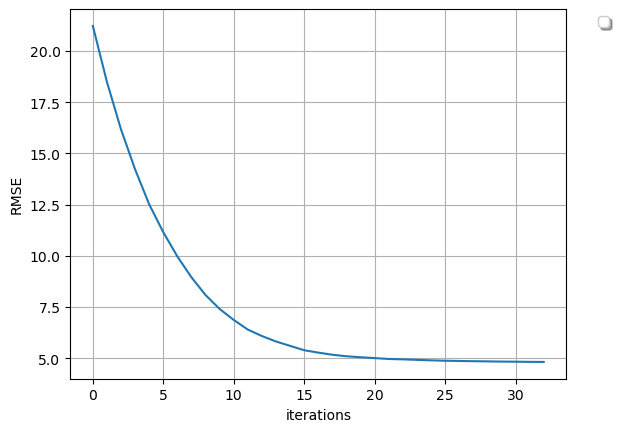


Weights/Theta's:
[22.83124058 -0.8364806   0.48317168 -0.10628337  0.88850696 -0.76023824
  3.23864455 -0.12864064 -2.05871796  0.62914905 -0.39052591 -1.7378846
  0.99578745 -3.85051914]

Train data:
SSE: 8207.536976962328 
RMSE: 4.815094256946941

Test data:
SSE: 3517.308161234733 
RMSE: 4.8104246456296496


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [19]:
params = {
    'gd': False,
    'sgd': True,
    'learning_rate': 0.0004,
    'epsilon': 0.005,
    'max_iteration': 50000,
    'reg_lambda': 0, 
}

sgd_housing = LinearRegression(X_h, y_h, **params)
train_rmse, test_rmse = sgd_housing.fit()

results_df = add_result(results_df, 'Housing', params, train_rmse, test_rmse)

### 1.6 Building Stochastic Gradient descent with regularization parameter

X is Full rank
X is not low rank
SGD


  0%|                                                                              | 25/50000 [00:00<05:26, 153.03it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


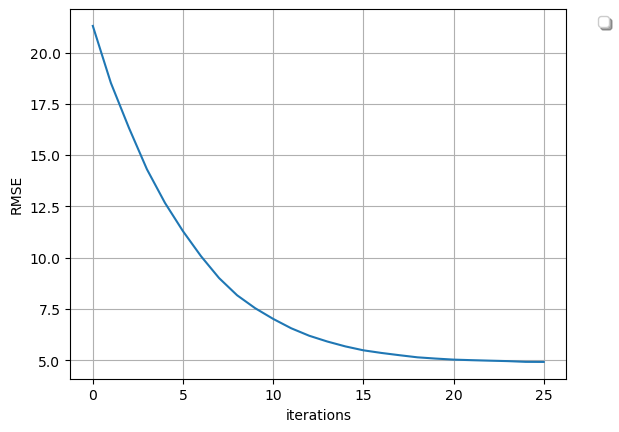


Weights/Theta's:
[22.20352873 -0.77167934  0.29028664 -0.20103807  0.97909278 -0.65886973
  3.00581514 -0.38929332 -1.72500066  0.4261137  -0.33147659 -1.96405764
  0.98406631 -3.54084082]

Train data:
SSE: 8552.641478301293 
RMSE: 4.915282715774582

Test data:
SSE: 3694.663572407055 
RMSE: 4.930212691850984


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [20]:
params = {
    'gd': False,
    'sgd': True,
    'learning_rate': 0.0004,
    'epsilon': 0.005,
    'max_iteration': 50000,
    'reg_lambda': 0.005, 
}

sgd_housing_l2 = LinearRegression(X_h, y_h, **params)
train_rmse, test_rmse = sgd_housing_l2.fit()

results_df = add_result(results_df, 'Housing', params, train_rmse, test_rmse)

### Summary of Hosuing Dataset

In [25]:
### Summary of Hosuing Dataset
results_df[results_df['Dataset']=='Housing']

,Dataset,GD,SGD,Reg Lambda,Learning Rate,Tolerance,Max Iteration,Train RMSE,Test RMSE
0,Housing,False,False,0,0.0004,0.005,50000,4.748211,4.638690
1,Housing,False,False,0.01,0.0004,0.005,50000,4.748211,4.638735
2,Housing,True,False,0,0.0004,0.005,50000,14.106301,13.458459
3,Housing,True,False,0,0.0400,0.005,50000,4.879834,4.891192
4,Housing,True,False,0.005,0.0004,0.005,50000,14.149066,13.497291
5,Housing,True,False,0.005,0.0400,0.005,50000,4.890501,4.900474
6,Housing,False,True,0,0.0004,0.005,50000,4.815094,4.810425
7,Housing,False,True,0.005,0.0004,0.005,50000,4.915283,4.930213


## Dataset 2: Yacht.csv

### 2.1 Building Closed form solution without regularization parameter

In [23]:
params = {
    'gd': False,
    'sgd': False,
    'learning_rate': 0.001,
    'epsilon': 0.001,
    'max_iteration': 50000,
    'reg_lambda': 0, 
}

closedform_yacht = LinearRegression(X_y, y_y, **params)
train_rmse, test_rmse = closedform_yacht.fit()

results_df = add_result(results_df, 'Yacht', params, train_rmse, test_rmse)

X is Full rank
X is not low rank

 Closed form solution is as follows

Weights/Theta's:
[11.47167442  0.36763904  0.1543742   0.38568654 -0.58304475 -0.54297284
 12.91236515]

Train data:
SSE: 17097.237538712412 
RMSE: 8.917512829470931

Test data:
SSE: 7231.268177948541 
RMSE: 8.8179119867403


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)


### 2.2 Building Closed form solution with regularization parameter


In [26]:
params = {
    'gd': False,
    'sgd': False,
    'learning_rate': 0.001,
    'epsilon': 0.001,
    'max_iteration': 50000,
    'reg_lambda': 0.0005, 
}

closedform_yacht_l2 = LinearRegression(X_y, y_y, **params)
train_rmse, test_rmse = closedform_yacht_l2.fit()

results_df = add_result(results_df, 'Yacht', params, train_rmse, test_rmse)

X is Full rank
X is not low rank

 Closed form solution is as follows

Weights/Theta's:
[11.47164774  0.3676385   0.15433635  0.38553941 -0.58291527 -0.54282607
 12.91233554]

Train data:
SSE: 17097.237539165555 
RMSE: 8.917512829589105

Test data:
SSE: 7231.25644347997 
RMSE: 8.817904832147876


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)


**Note**: There is no impact of regularization parameters or learning parameters on RMSE. This may be because either of the following reasons: 

1. Low multicollinearity
2. Proper feature scaling


### 2.3 Building gradient descent without regularization parameter


X is Full rank
X is not low rank


  3%|██▌                                                                       | 1727/50000 [00:00<00:01, 29698.91it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


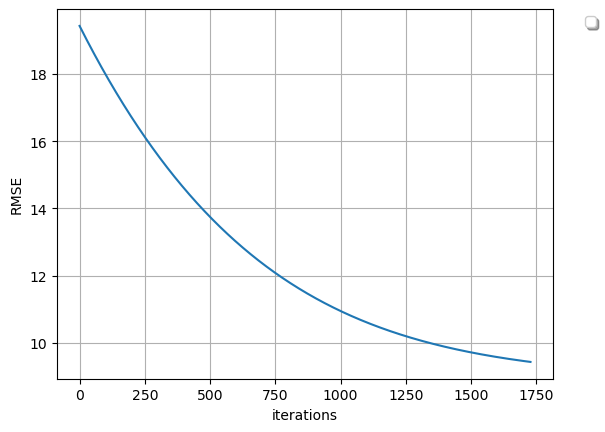


Weights/Theta's:
[ 9.43561491  0.34135666 -0.03918701 -0.11722466  0.02563103 -0.20851464
 10.60466454]

Train data:
SSE: 19135.026269644302 
RMSE: 9.433987607814212

Test data:
SSE: 6964.293210741014 
RMSE: 8.653604638170982


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [28]:
params = {
    'gd': True,
    'sgd': False,
    'learning_rate': 0.001,
    'epsilon': 0.001,
    'max_iteration': 50000,
    'reg_lambda': 0, 
}

gd_yacht = LinearRegression(X_y, y_y, **params)
train_rmse, test_rmse = gd_yacht.fit()

results_df = add_result(results_df, 'Yacht', params, train_rmse, test_rmse)

### 2.4 Building gradient descent with regularization parameter


X is Full rank
X is not low rank


  3%|██▌                                                                       | 1728/50000 [00:00<00:01, 30433.20it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


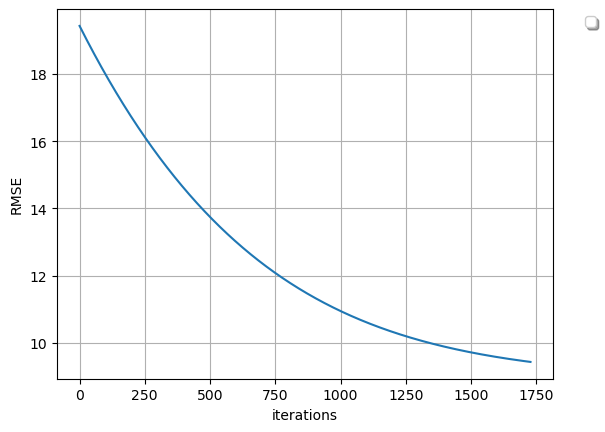


Weights/Theta's:
[ 9.43173654  0.34121498 -0.0391544  -0.11718742  0.02562112 -0.20843863
 10.60031029]

Train data:
SSE: 19142.718368856775 
RMSE: 9.435883604095142

Test data:
SSE: 6965.065928862339 
RMSE: 8.654084702080159


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [29]:
params = {
    'gd': True,
    'sgd': False,
    'learning_rate': 0.001,
    'epsilon': 0.001,
    'max_iteration': 50000,
    'reg_lambda': 0.001, 
}

gd_yacht_l2 = LinearRegression(X_y, y_y, **params)
train_rmse, test_rmse = gd_yacht_l2.fit()

results_df = add_result(results_df, 'Yacht', params, train_rmse, test_rmse)

### 2.5 Building Stochastic gradient descent without regularization parameter

X is Full rank
X is not low rank
SGD


  0%|                                                                              | 20/50000 [00:00<05:18, 157.05it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


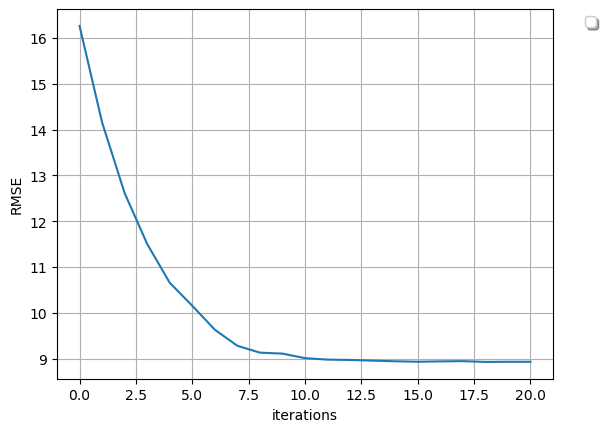


Weights/Theta's:
[11.2825738   0.20325317 -0.30768869 -0.20852167 -0.04303502 -0.30089845
 12.7047351 ]

Train data:
SSE: 17164.213838217387 
RMSE: 8.934962380217101

Test data:
SSE: 7100.378473568493 
RMSE: 8.737743165701813


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [31]:
params = {
    'gd': False,
    'sgd': True,
    'learning_rate': 0.001,
    'epsilon': 0.001,
    'max_iteration': 50000,
    'reg_lambda':0, 
}

sgd_yacht = LinearRegression(X_y, y_y, **params)
train_rmse, test_rmse = sgd_yacht.fit()

results_df = add_result(results_df, 'Yacht', params, train_rmse, test_rmse)

### 2.6 Building Stochastic gradient descent without regularization parameter

X is Full rank
X is not low rank
SGD


  0%|                                                                              | 16/50000 [00:00<03:04, 271.34it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


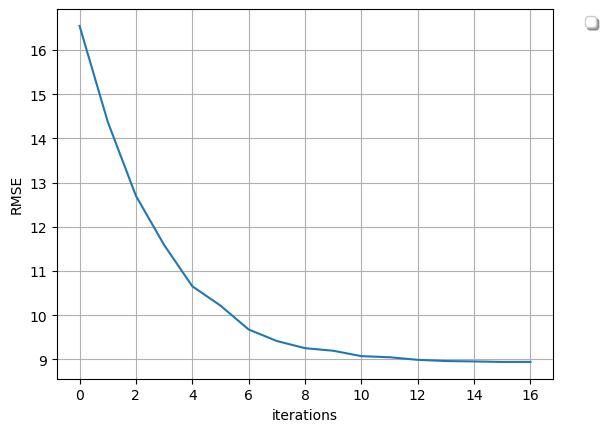


Weights/Theta's:
[ 1.10548211e+01  6.25968074e-01 -1.64092092e-01  7.50728983e-02
  7.14755062e-03 -2.82806764e-01  1.25657506e+01]

Train data:
SSE: 17198.132862876675 
RMSE: 8.943786426412856

Test data:
SSE: 7077.4534219613215 
RMSE: 8.723625949025372


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [32]:
params = {
    'gd': False,
    'sgd': True,
    'learning_rate': 0.001,
    'epsilon': 0.001,
    'max_iteration': 50000,
    'reg_lambda':0.001, 
}

sgd_yacht_l2 = LinearRegression(X_y, y_y, **params)
train_rmse, test_rmse = sgd_yacht_l2.fit()

results_df = add_result(results_df, 'Yacht', params, train_rmse, test_rmse)

### Summary of Yatch Dataset

In [36]:
### Summary of Yacht Dataset
results_df[results_df['Dataset']=='Yacht']

,Dataset,GD,SGD,Reg Lambda,Learning Rate,Tolerance,Max Iteration,Train RMSE,Test RMSE
8,Yacht,False,False,0,0.001,0.001,50000,8.917513,8.817912
9,Yacht,False,False,0.0005,0.001,0.001,50000,8.917513,8.817905
10,Yacht,True,False,0,0.001,0.001,50000,9.433988,8.653605
11,Yacht,True,False,0.001,0.001,0.001,50000,9.435884,8.654085
12,Yacht,False,True,0,0.001,0.001,50000,8.934962,8.737743
13,Yacht,False,True,0.001,0.001,0.001,50000,8.943786,8.723626


## Dataset 3: Concrete.csv

### 3.1 Building closed form solution without regularization parameter

In [37]:
params = {
    'gd': False,
    'sgd': False,
    'learning_rate': 0.0007,
    'epsilon': 0.0001,
    'max_iteration': 50000,
    'reg_lambda': 0, 
}

closedform_concrete = LinearRegression(X_c, y_c, **params)
train_rmse, test_rmse = closedform_concrete.fit()

results_df = add_result(results_df, 'Concrete', params, train_rmse, test_rmse)

X is Full rank
X is not low rank

 Closed form solution is as follows

Weights/Theta's:
[36.15273232 13.5859155  10.23748839  5.73058513 -1.91518897  2.39568132
  2.20535389  2.91260295  7.01972961]

Train data:
SSE: 77319.99582299095 
RMSE: 10.355671814428208

Test data:
SSE: 33912.99966277452 
RMSE: 10.476201982118523


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)


### 3.2 Building closed form solution with regularization parameter

In [38]:
params = {
    'gd': False,
    'sgd': False,
    'learning_rate': 0.0007,
    'epsilon': 0.0001,
    'max_iteration': 50000,
    'reg_lambda': 0.001, 
}

closedform_concrete_l2= LinearRegression(X_c, y_c, **params)
train_rmse, test_rmse = closedform_concrete_l2.fit()

results_df = add_result(results_df, 'Concrete', params, train_rmse, test_rmse)

X is Full rank
X is not low rank

 Closed form solution is as follows

Weights/Theta's:
[36.15268217 13.58559591 10.23717825  5.73031371 -1.91540127  2.39567851
  2.20513878  2.91232736  7.01970682]

Train data:
SSE: 77319.99583491284 
RMSE: 10.355671815226572

Test data:
SSE: 33912.92876696519 
RMSE: 10.476191031757102


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


### 3.3 Building gradient descent without regularization parameter

X is Full rank
X is not low rank


 10%|███████▋                                                                  | 5181/50000 [00:00<00:01, 25296.13it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


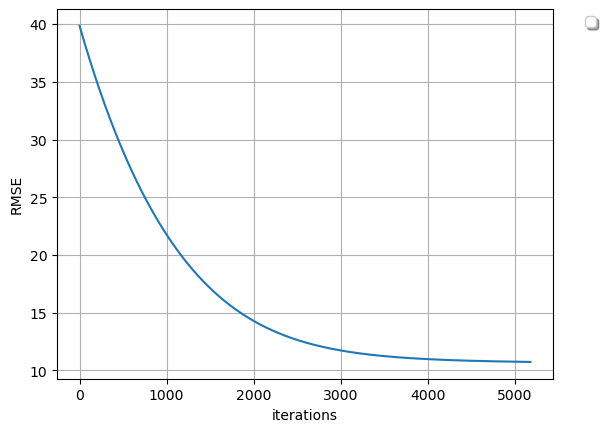


Weights/Theta's:
[35.19282415  6.92162193  3.5921067  -0.404856   -4.87848019  3.86622842
 -1.58107816 -2.40300609  6.32670235]

Train data:
SSE: 83164.420559425 
RMSE: 10.739922577729512

Test data:
SSE: 35718.66302280116 
RMSE: 10.751482628668796


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [40]:
params = {
    'gd': True,
    'sgd': False,
    'learning_rate': 0.0007,
    'epsilon': 0.0001,
    'max_iteration': 50000,
    'reg_lambda': 0, 
}

gd_concrete= LinearRegression(X_c, y_c, **params)
train_rmse, test_rmse = gd_concrete.fit()

results_df = add_result(results_df, 'Concrete', params, train_rmse, test_rmse)

### 3.4 Building gradient descent with regularization parameter

X is Full rank
X is not low rank


 10%|███████▋                                                                  | 5200/50000 [00:00<00:01, 23591.75it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


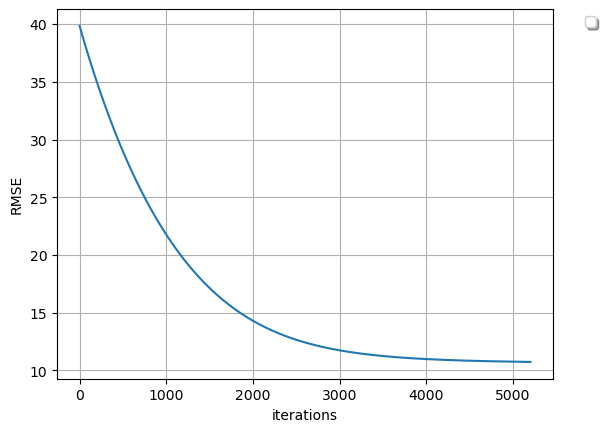


Weights/Theta's:
[35.17378172  6.91997651  3.5928508  -0.40171175 -4.87724519  3.86131569
 -1.57977797 -2.40043845  6.32410282]

Train data:
SSE: 83189.40343422219 
RMSE: 10.741535611234058

Test data:
SSE: 35724.82028128989 
RMSE: 10.752409270365549


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [41]:
params = {
    'gd': True,
    'sgd': False,
    'learning_rate': 0.0007,
    'epsilon': 0.0001,
    'max_iteration': 50000,
    'reg_lambda': 0.001, 
}

gd_concrete_l2= LinearRegression(X_c, y_c, **params)
train_rmse, test_rmse = gd_concrete_l2.fit()

results_df = add_result(results_df, 'Concrete', params, train_rmse, test_rmse)

### 3.5 Building Stochastic gradient descent without regularization parameter

X is Full rank
X is not low rank
SGD


  1%|▍                                                                            | 269/50000 [00:02<07:38, 108.58it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


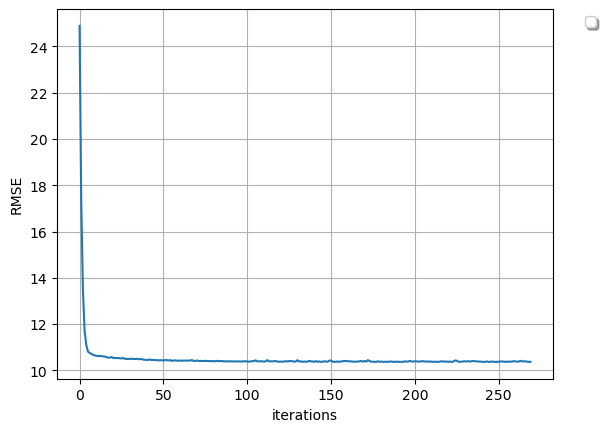


Weights/Theta's:
[35.98320478 13.43970297 10.22848766  5.82182135 -1.98137604  2.14973265
  2.23036032  2.67864268  7.15384999]

Train data:
SSE: 77452.77764563006 
RMSE: 10.364559910759889

Test data:
SSE: 33719.46409387032 
RMSE: 10.446266283614866


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [42]:
params = {
    'gd': False,
    'sgd': True,
    'learning_rate': 0.0007,
    'epsilon': 0.0001,
    'max_iteration': 50000,
    'reg_lambda': 0, 
}

sgd_concrete = LinearRegression(X_c, y_c, **params)
train_rmse, test_rmse = sgd_concrete.fit()

results_df = add_result(results_df, 'Concrete', params, train_rmse, test_rmse)

### 3.6 Building Stochastic gradient descent with regularization parameter


X is Full rank
X is not low rank
SGD


  0%|▎                                                                            | 237/50000 [00:02<07:22, 112.56it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


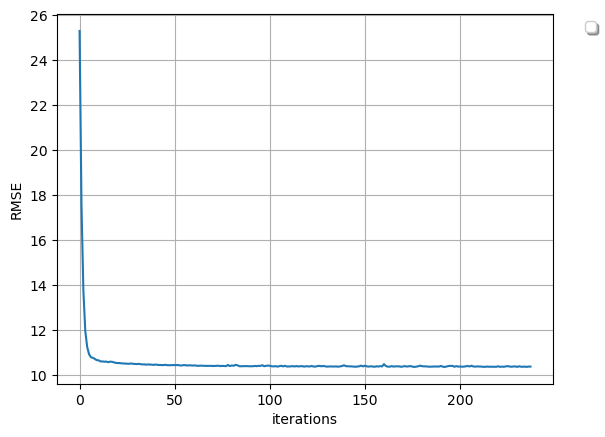


Weights/Theta's:
[36.33821961 13.4536178   9.64806145  5.85045436 -2.36002388  2.21805615
  1.9887411   2.64221286  7.01226999]

Train data:
SSE: 77608.320277474 
RMSE: 10.374961877006577

Test data:
SSE: 33186.98892209932 
RMSE: 10.363457851874085


C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_row, ignore_index=True)
C:\Users\Bal4\AppData\Local\Temp\ipykernel_21408\2971123851.py:17: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_row, ignore_index=True)


In [43]:
params = {
    'gd': False,
    'sgd': True,
    'learning_rate': 0.0007,
    'epsilon': 0.0001,
    'max_iteration': 50000,
    'reg_lambda': 0.001, 
}

sgd_concrete_l2 = LinearRegression(X_c, y_c, **params)
train_rmse, test_rmse = sgd_concrete_l2.fit()

results_df = add_result(results_df, 'Concrete', params, train_rmse, test_rmse)

### Summary of Concrete Dataset

In [45]:
### Summary of Concrete Dataset
results_df[results_df['Dataset']=='Concrete']

,Dataset,GD,SGD,Reg Lambda,Learning Rate,Tolerance,Max Iteration,Train RMSE,Test RMSE
14,Concrete,False,False,0,0.0007,0.0001,50000,10.355672,10.476202
15,Concrete,False,False,0.001,0.0007,0.0001,50000,10.355672,10.476191
16,Concrete,True,False,0,0.0007,0.0001,50000,10.739923,10.751483
17,Concrete,True,False,0.001,0.0007,0.0001,50000,10.741536,10.752409
18,Concrete,False,True,0,0.0007,0.0001,50000,10.364560,10.446266
19,Concrete,False,True,0.001,0.0007,0.0001,50000,10.374962,10.363458


## 4. Evaluating results

In [46]:
results_df

,Dataset,GD,SGD,Reg Lambda,Learning Rate,Tolerance,Max Iteration,Train RMSE,Test RMSE
0,Housing,False,False,0,0.0004,0.0050,50000,4.748211,4.638690
1,Housing,False,False,0.01,0.0004,0.0050,50000,4.748211,4.638735
2,Housing,True,False,0,0.0004,0.0050,50000,14.106301,13.458459
3,Housing,True,False,0,0.0400,0.0050,50000,4.879834,4.891192
4,Housing,True,False,0.005,0.0004,0.0050,50000,14.149066,13.497291
5,Housing,True,False,0.005,0.0400,0.0050,50000,4.890501,4.900474
6,Housing,False,True,0,0.0004,0.0050,50000,4.815094,4.810425
7,Housing,False,True,0.005,0.0004,0.0050,50000,4.915283,4.930213
8,Yacht,False,False,0,0.0010,0.0010,50000,8.917513,8.817912
9,Yacht,False,False,0.0005,0.0010,0.0010,50000,8.917513,8.817905


In the above we observed how different datasets perform on Closed form solution, Gradient descent and Stochastic gradient descent. We also tried to tweak learning rates and regularization parameters to observe how hyperparameter tuning can lead to a major difference in the performance. 

### Understanding effects of the learning rate and regularization parameters on the learning

**On Housing dataset**

Training with learning rate: 0.2, regularization: 0.0005
X is Full rank
X is not low rank


  0%|                                                                            | 22/50000 [00:00<00:04, 10398.32it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


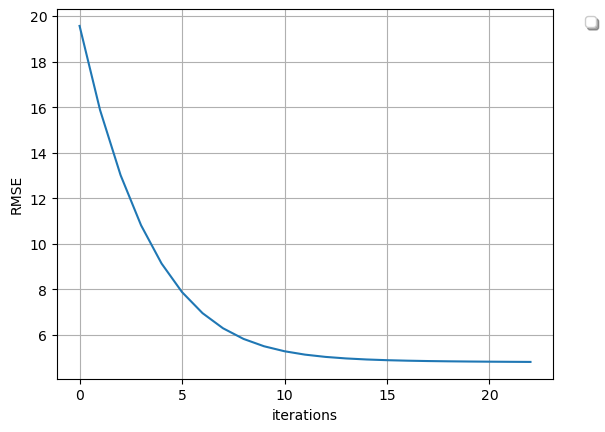


Weights/Theta's:
[22.8689134  -0.83609442  0.3450238  -0.14970088  0.94389803 -0.81876077
  3.2546196  -0.32947817 -1.94940421  0.64920708 -0.2787863  -1.8249638
  1.0115199  -3.68868235]

Train data:
SSE: 8205.97584243364 
RMSE: 4.814636301813367

Test data:
SSE: 3534.5602602916197 
RMSE: 4.8222075777563935
Training with learning rate: 0.2, regularization: 0.001
X is Full rank
X is not low rank


  0%|                                                                            | 22/50000 [00:00<00:04, 11003.42it/s]

Model stopped learning



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


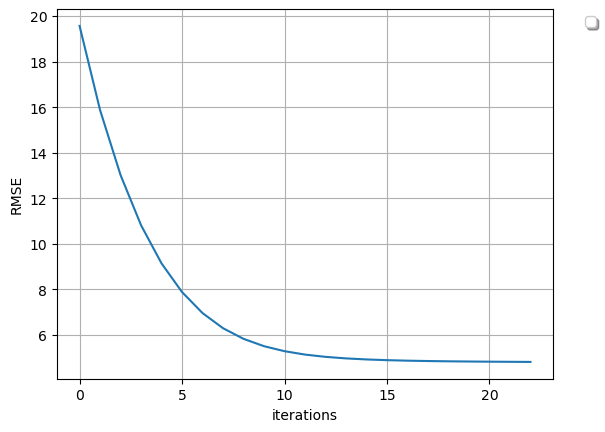


Weights/Theta's:
[22.85787897 -0.83578463  0.34493859 -0.15009244  0.94393296 -0.81811311
  3.25370547 -0.32934332 -1.94764406  0.64821196 -0.27894097 -1.82433257
  1.01111892 -3.68695361]

Train data:
SSE: 8207.639772993296 
RMSE: 4.815124410391873

Test data:
SSE: 3535.206293833186 
RMSE: 4.822648250042644
Training with learning rate: 0.2, regularization: 0.005
X is Full rank
X is not low rank


  0%|                                                                             | 23/50000 [00:00<00:05, 8764.33it/s]

Model stopped learning



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


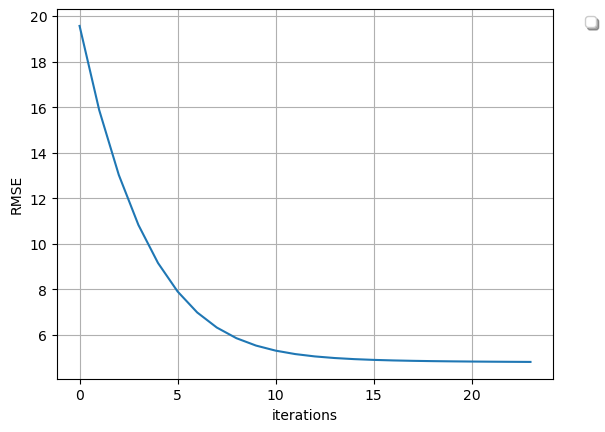


Weights/Theta's:
[22.79636249 -0.84111962  0.35322666 -0.14475777  0.93733573 -0.83951448
  3.23512901 -0.33323477 -1.96851953  0.66267073 -0.28624918 -1.82646578
  1.01036291 -3.68829189]

Train data:
SSE: 8208.313037611759 
RMSE: 4.8153218963019455

Test data:
SSE: 3533.3087049369396 
RMSE: 4.821353752439669
Training with learning rate: 0.2, regularization: 0.01
X is Full rank
X is not low rank


  0%|                                                                            | 24/50000 [00:00<00:04, 10513.14it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


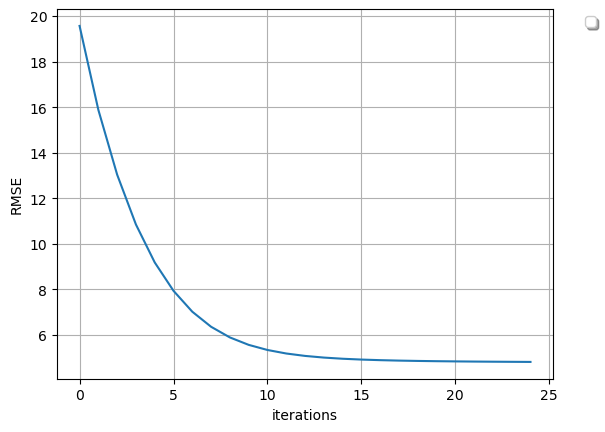


Weights/Theta's:
[22.70707169 -0.84516145  0.36093158 -0.14097748  0.93184407 -0.85778811
  3.21544095 -0.33611938 -1.98292376  0.6735256  -0.29405863 -1.82679745
  1.00830316 -3.68421711]

Train data:
SSE: 8219.701698928095 
RMSE: 4.818661258550515

Test data:
SSE: 3535.506376373154 
RMSE: 4.822852928596933
Training with learning rate: 0.2, regularization: 0.05
X is Full rank
X is not low rank


  0%|                                                                             | 26/50000 [00:00<00:05, 9555.06it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


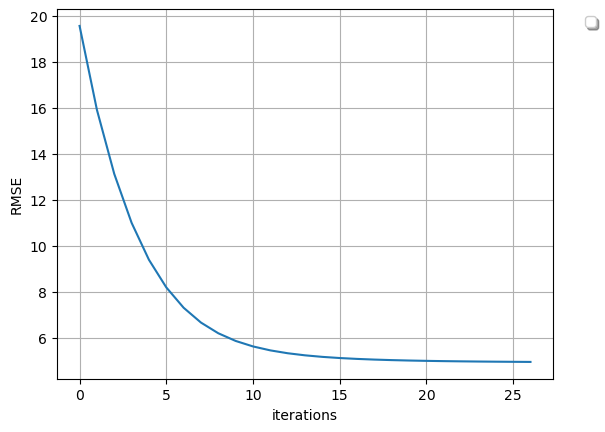


Weights/Theta's:
[21.88209071 -0.83033962  0.36591888 -0.16108953  0.92744846 -0.84062212
  3.13114891 -0.3305053  -1.8888872   0.62476134 -0.31527415 -1.78661543
  0.97943299 -3.56693628]

Train data:
SSE: 8678.426973016834 
RMSE: 4.951295833643042

Test data:
SSE: 3708.2561949374485 
RMSE: 4.939273462273049
Training with learning rate: 0.2, regularization: 0.1
X is Full rank
X is not low rank


  0%|                                                                            | 26/50000 [00:00<00:03, 14232.82it/s]

Model stopped learning



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


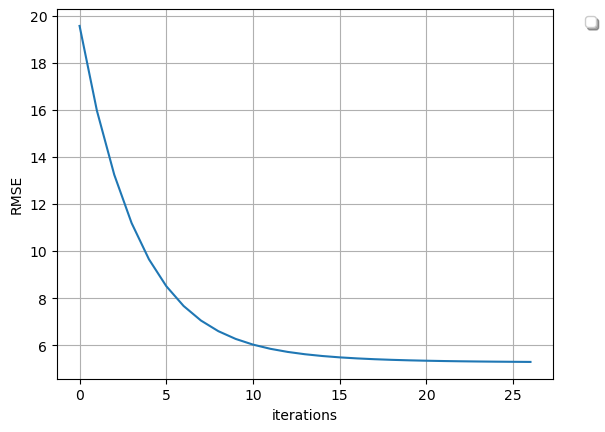


Weights/Theta's:
[20.89793394 -0.79900555  0.35332567 -0.198829    0.93076844 -0.77071871
  3.0539535  -0.31722189 -1.71757595  0.52684705 -0.32412287 -1.72602665
  0.94329408 -3.40757285]

Train data:
SSE: 9908.91017785942 
RMSE: 5.290677809966168

Test data:
SSE: 4183.385551891243 
RMSE: 5.246167493295038
Training with learning rate: 0.2, regularization: 0.5
X is Full rank
X is not low rank


  0%|                                                                             | 19/50000 [00:00<00:05, 9499.56it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


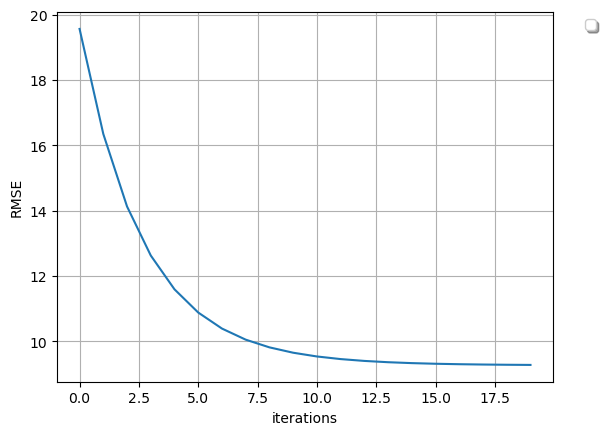


Weights/Theta's:
[15.33163624 -0.6444182   0.30726277 -0.36852137  0.88071006 -0.47644063
  2.53128053 -0.27115782 -0.88240173  0.06582648 -0.37626353 -1.38322224
  0.74714734 -2.54801257]

Train data:
SSE: 30455.703149734676 
RMSE: 9.27540078622014

Test data:
SSE: 12053.501183459022 
RMSE: 8.905018242046323
Training with learning rate: 0.1, regularization: 0.0005
X is Full rank
X is not low rank


  0%|                                                                            | 40/50000 [00:00<00:02, 18728.75it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


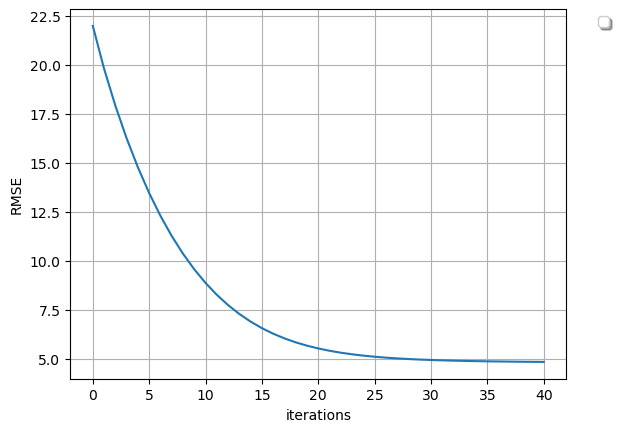


Weights/Theta's:
[22.69899162 -0.81275688  0.32342988 -0.17644638  0.97085981 -0.74487801
  3.28033908 -0.31103441 -1.84281817  0.58334476 -0.27024426 -1.80393782
  0.99918336 -3.63082208]

Train data:
SSE: 8270.443603789805 
RMSE: 4.833511667406447

Test data:
SSE: 3565.2007672707277 
RMSE: 4.843063927487275
Training with learning rate: 0.1, regularization: 0.001
X is Full rank
X is not low rank


  0%|                                                                            | 40/50000 [00:00<00:03, 13267.87it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


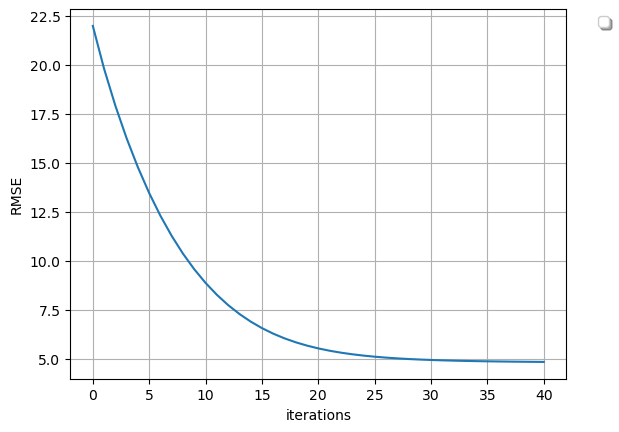


Weights/Theta's:
[22.68834785 -0.81249348  0.32338508 -0.17678387  0.97083799 -0.7443748
  3.27937858 -0.31093782 -1.84127167  0.58248079 -0.27041136 -1.80334834
  0.99880952 -3.6292152 ]

Train data:
SSE: 8273.360547095273 
RMSE: 4.834363969726996

Test data:
SSE: 3566.347160176667 
RMSE: 4.843842510272209
Training with learning rate: 0.1, regularization: 0.005
X is Full rank
X is not low rank


  0%|                                                                                       | 41/50000 [00:00<?, ?it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


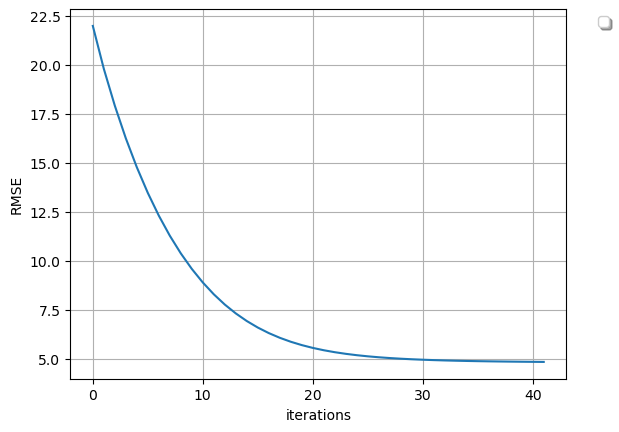


Weights/Theta's:
[22.63345169 -0.81475497  0.32726996 -0.17449335  0.96586584 -0.75444345
  3.26677069 -0.31344237 -1.84891836  0.58810043 -0.27374186 -1.80262262
  0.99797189 -3.62686359]

Train data:
SSE: 8283.847075119897 
RMSE: 4.837426790383095

Test data:
SSE: 3569.2650848641615 
RMSE: 4.845823679960324
Training with learning rate: 0.1, regularization: 0.01
X is Full rank
X is not low rank


  0%|                                                                            | 42/50000 [00:00<00:03, 13862.19it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


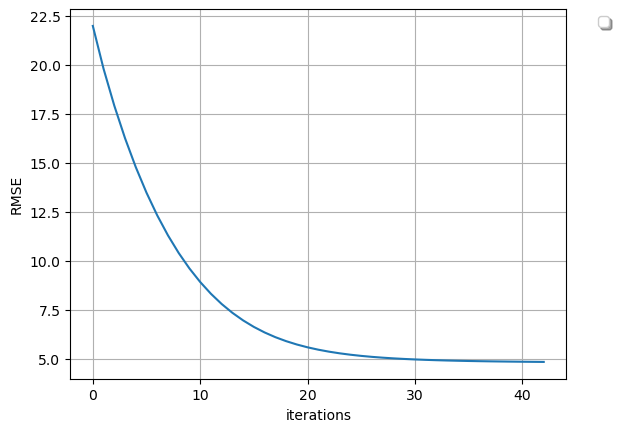


Weights/Theta's:
[22.55385577 -0.81625005  0.33093929 -0.17318138  0.96126898 -0.76283938
  3.25237528 -0.3154893  -1.85233545  0.59133066 -0.27750016 -1.80052085
  0.99616445 -3.62047239]

Train data:
SSE: 8305.969627220187 
RMSE: 4.843881814964643

Test data:
SSE: 3576.708364131431 
RMSE: 4.850873743957067
Training with learning rate: 0.1, regularization: 0.05
X is Full rank
X is not low rank


  0%|                                                                            | 47/50000 [00:00<00:03, 12525.88it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


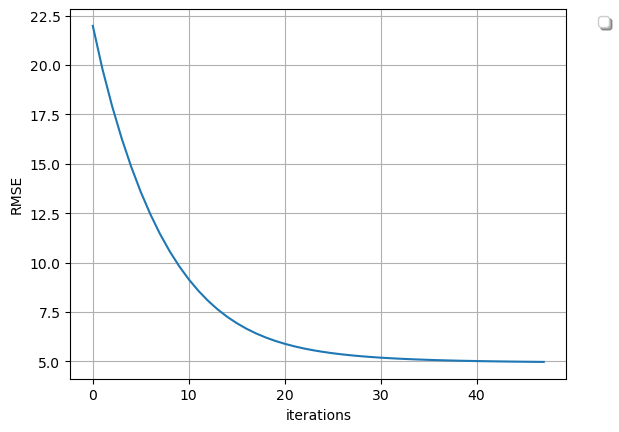


Weights/Theta's:
[21.81308398 -0.81145632  0.34426716 -0.1816485   0.94419229 -0.77626513
  3.15797189 -0.31853954 -1.80411526  0.5702207  -0.30056464 -1.76923705
  0.97339007 -3.52993418]

Train data:
SSE: 8767.067745712826 
RMSE: 4.976517667529572

Test data:
SSE: 3749.3335623704115 
RMSE: 4.9665549602807735
Training with learning rate: 0.1, regularization: 0.1
X is Full rank
X is not low rank


  0%|                                                                            | 48/50000 [00:00<00:03, 15818.86it/s]


Model stopped learning


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


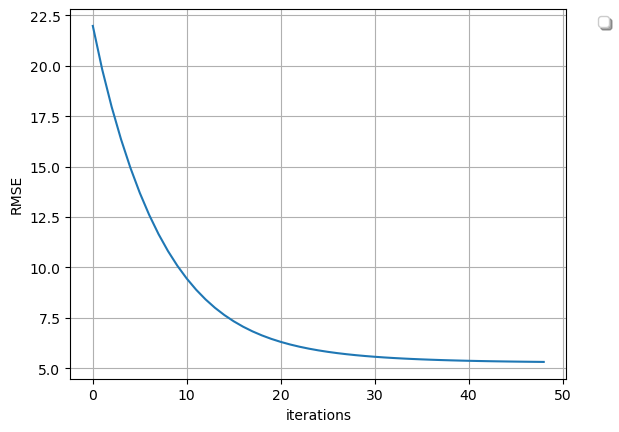


Weights/Theta's:
[20.85417028 -0.78653849  0.33893478 -0.2123688   0.94169692 -0.72813246
  3.07182706 -0.30937988 -1.66164768  0.49084337 -0.31425678 -1.71454117
  0.93940231 -3.38337461]

Train data:
SSE: 9999.380968671947 
RMSE: 5.314775526262

Test data:
SSE: 4223.918651787928 
RMSE: 5.2715214595603035
Training with learning rate: 0.1, regularization: 0.5
X is Full rank
X is not low rank


  0%|                                                                            | 38/50000 [00:00<00:04, 10220.17it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


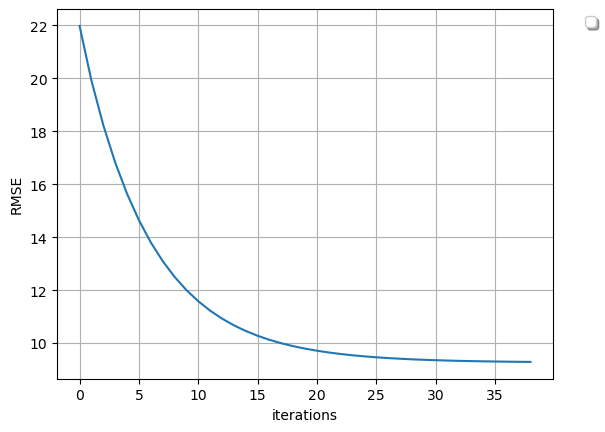


Weights/Theta's:
[15.3167605  -0.64295194  0.30614897 -0.37026985  0.88270485 -0.47205636
  2.53252597 -0.26983178 -0.87560538  0.06173901 -0.37617239 -1.38192221
  0.74613776 -2.54379278]

Train data:
SSE: 30543.28774834967 
RMSE: 9.288728323370997

Test data:
SSE: 12088.878607430957 
RMSE: 8.918076928436951
Training with learning rate: 0.01, regularization: 0.0005
X is Full rank
X is not low rank


  1%|▍                                                                          | 271/50000 [00:00<00:01, 29771.77it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


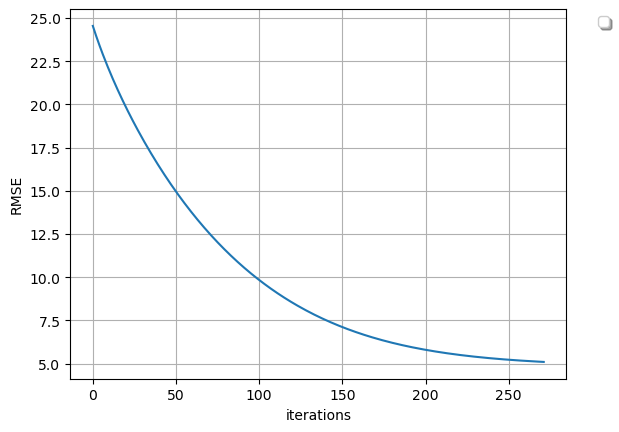


Weights/Theta's:
[21.51157191 -0.74295851  0.27715076 -0.2686192   1.06580076 -0.53684778
  3.28950555 -0.25058564 -1.48471536  0.36375221 -0.2782606  -1.73058526
  0.93909006 -3.38018489]

Train data:
SSE: 9198.764146879383 
RMSE: 5.097568974958704

Test data:
SSE: 3959.653003903755 
RMSE: 5.103954222942553
Training with learning rate: 0.01, regularization: 0.001
X is Full rank
X is not low rank


  1%|▍                                                                          | 271/50000 [00:00<00:02, 16703.99it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


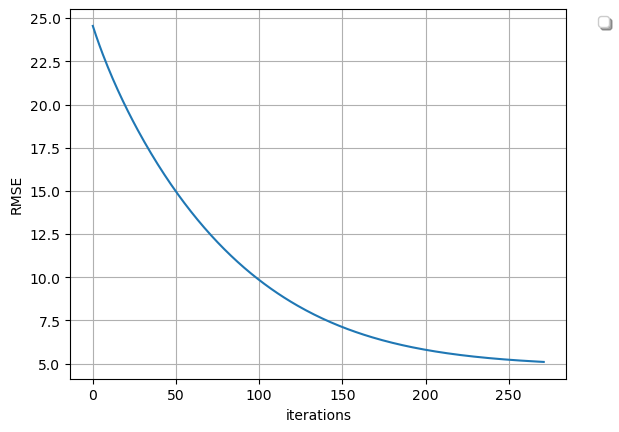


Weights/Theta's:
[21.50287509 -0.74280959  0.27718153 -0.26880554  1.06562238 -0.53668539
  3.28852967 -0.25058864 -1.48375572  0.36324792 -0.27841394 -1.7301157
  0.93881506 -3.37898927]

Train data:
SSE: 9208.655851356958 
RMSE: 5.100309022253189

Test data:
SSE: 3963.51943068974 
RMSE: 5.106445508200589
Training with learning rate: 0.01, regularization: 0.005
X is Full rank
X is not low rank


  1%|▍                                                                          | 273/50000 [00:00<00:01, 25767.83it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


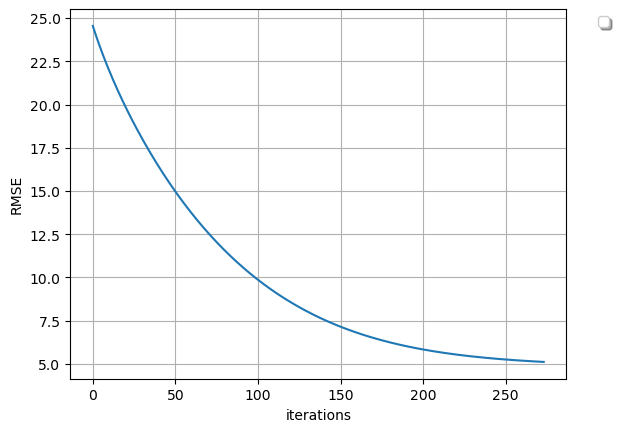


Weights/Theta's:
[21.46286649 -0.74267657  0.2778644  -0.26869207  1.0626963  -0.53834597
  3.28181315 -0.25153935 -1.48224991  0.36297396 -0.27902832 -1.72773647
  0.93787186 -3.37452605]

Train data:
SSE: 9253.393275069597 
RMSE: 5.11268315325919

Test data:
SSE: 3980.1962552565356 
RMSE: 5.117177120182505
Training with learning rate: 0.01, regularization: 0.01
X is Full rank
X is not low rank


  1%|▍                                                                          | 275/50000 [00:00<00:02, 21474.01it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


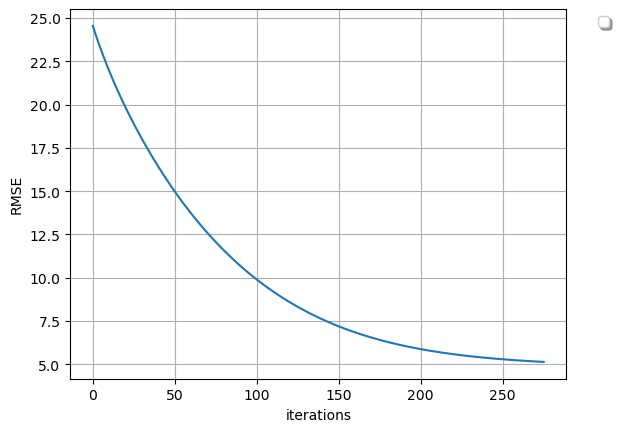


Weights/Theta's:
[21.40465835 -0.74222513  0.27860543 -0.26898876  1.05945547 -0.53962296
  3.27310804 -0.25247354 -1.47868684  0.36160546 -0.27997376 -1.72439115
  0.93634616 -3.36754599]

Train data:
SSE: 9321.349695202389 
RMSE: 5.1314224454951125

Test data:
SSE: 4005.9222585381913 
RMSE: 5.1336879239888695
Training with learning rate: 0.01, regularization: 0.05
X is Full rank
X is not low rank


  1%|▍                                                                          | 286/50000 [00:00<00:02, 24021.69it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


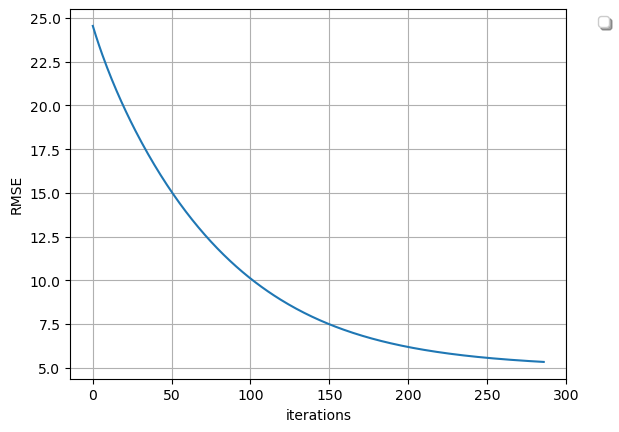


Weights/Theta's:
[20.86015616 -0.73561548  0.28321033 -0.27589649  1.03831524 -0.54120046
  3.20128775 -0.25710514 -1.43295154  0.34007    -0.28922527 -1.6940906
  0.92064983 -3.2977752 ]

Train data:
SSE: 10086.359641185096 
RMSE: 5.337840514597634

Test data:
SSE: 4298.719747051127 
RMSE: 5.317993133451907
Training with learning rate: 0.01, regularization: 0.1
X is Full rank
X is not low rank


  1%|▍                                                                          | 293/50000 [00:00<00:01, 26659.68it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


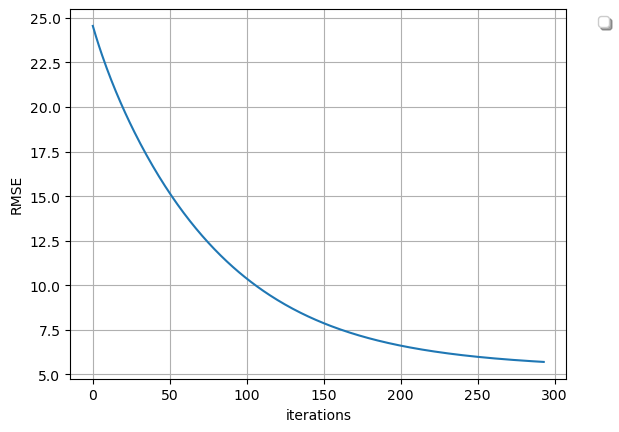


Weights/Theta's:
[20.11373594 -0.72392272  0.28696173 -0.28938101  1.01808715 -0.53268256
  3.11215946 -0.25932412 -1.35760229  0.30183561 -0.30195581 -1.65310419
  0.89763107 -3.19731091]

Train data:
SSE: 11501.16679308896 
RMSE: 5.699927344439551

Test data:
SSE: 4842.112038901367 
RMSE: 5.644111998882556
Training with learning rate: 0.01, regularization: 0.5
X is Full rank
X is not low rank


  0%|▎                                                                          | 246/50000 [00:00<00:01, 28766.55it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


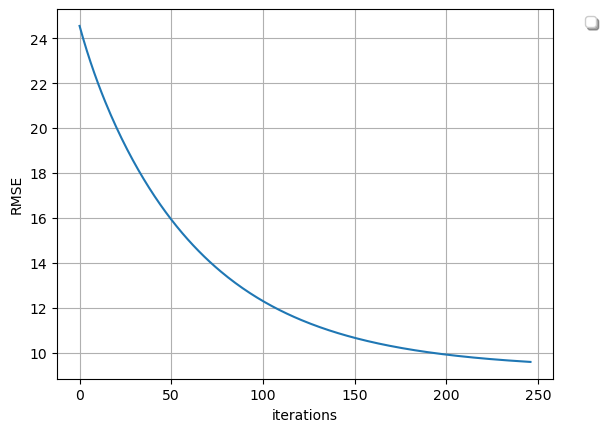


Weights/Theta's:
[ 1.49768642e+01 -6.26947866e-01  2.97093389e-01 -3.92615999e-01
  9.04812335e-01 -4.25508156e-01  2.52742973e+00 -2.55913938e-01
 -7.89153266e-01  8.87450817e-03 -3.80892623e-01 -1.36354629e+00
  7.30336831e-01 -2.47870361e+00]

Train data:
SSE: 32550.970796926365 
RMSE: 9.589155067396275

Test data:
SSE: 12885.882172358075 
RMSE: 9.207363390657441
Training with learning rate: 0.001, regularization: 0.0005
X is Full rank
X is not low rank


  3%|█▉                                                                        | 1315/50000 [00:00<00:02, 22935.71it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


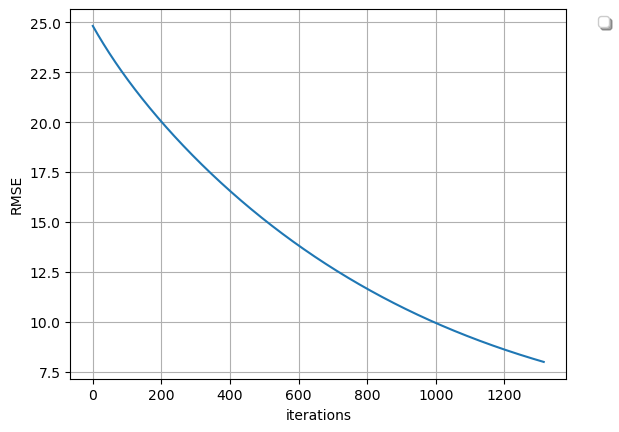


Weights/Theta's:
[ 1.68425426e+01 -6.68132212e-01  2.94758732e-01 -4.27050913e-01
  1.09429913e+00 -3.80608837e-01  2.88975086e+00 -2.22671326e-01
 -8.61790088e-01 -4.80209924e-03 -4.01189741e-01 -1.53177808e+00
  7.91257263e-01 -2.73476828e+00]

Train data:
SSE: 22584.339468426544 
RMSE: 7.987338049678941

Test data:
SSE: 9270.447094896474 
RMSE: 7.809595605347036
Training with learning rate: 0.001, regularization: 0.001
X is Full rank
X is not low rank


  3%|█▉                                                                        | 1315/50000 [00:00<00:01, 31818.11it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


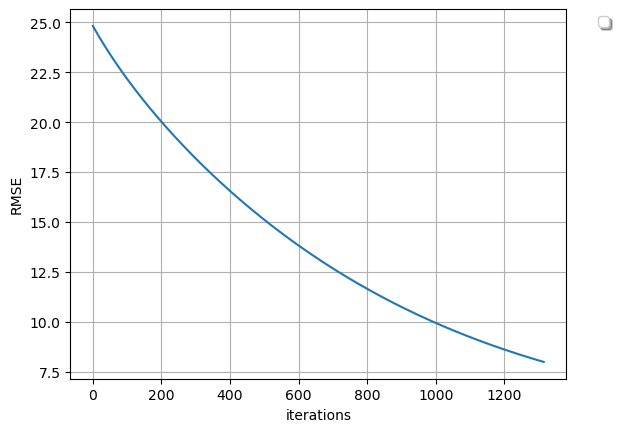


Weights/Theta's:
[ 1.68381849e+01 -6.68058576e-01  2.94778476e-01 -4.27083976e-01
  1.09407753e+00 -3.80612169e-01  2.88912996e+00 -2.22709246e-01
 -8.61430913e-01 -4.94947348e-03 -4.01229634e-01 -1.53149269e+00
  7.91123351e-01 -2.73418250e+00]

Train data:
SSE: 22604.32440074061 
RMSE: 7.990871274830154

Test data:
SSE: 9278.02868105631 
RMSE: 7.812788386701029
Training with learning rate: 0.001, regularization: 0.005
X is Full rank
X is not low rank


  3%|█▉                                                                        | 1312/50000 [00:00<00:01, 29689.06it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


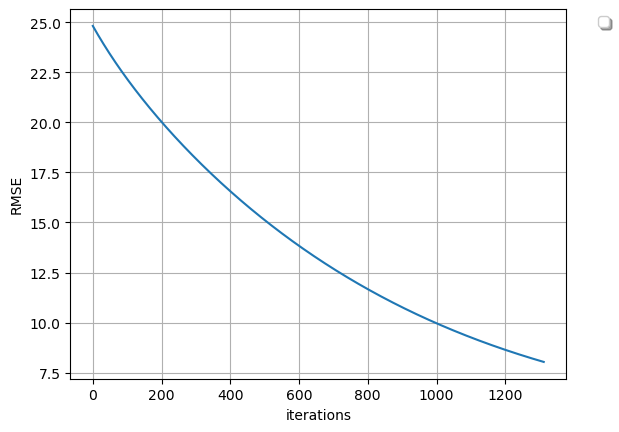


Weights/Theta's:
[ 1.67849615e+01 -6.67313070e-01  2.95138193e-01 -4.27819977e-01
  1.09191265e+00 -3.80558832e-01  2.88212380e+00 -2.23161063e-01
 -8.56627041e-01 -7.21070713e-03 -4.02032746e-01 -1.52836682e+00
  7.89571277e-01 -2.72719913e+00]

Train data:
SSE: 22849.441838334526 
RMSE: 8.034080275364534

Test data:
SSE: 9371.926584956518 
RMSE: 7.852223363044061
Training with learning rate: 0.001, regularization: 0.01
X is Full rank
X is not low rank


  3%|█▉                                                                        | 1309/50000 [00:00<00:02, 18132.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


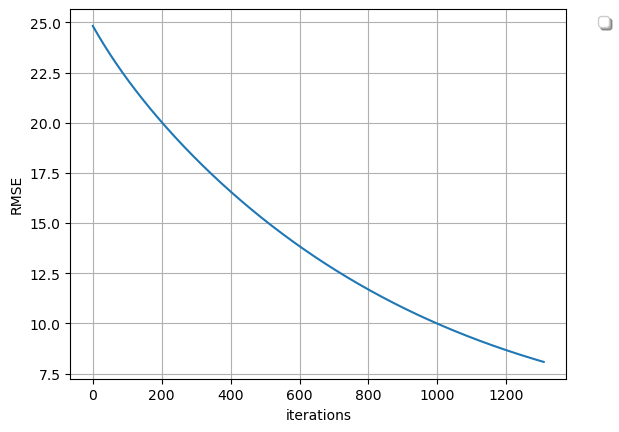


Weights/Theta's:
[ 1.67233748e+01 -6.66424099e-01  2.95534188e-01 -4.28613939e-01
  1.08931285e+00 -3.80514420e-01  2.87391598e+00 -2.23686395e-01
 -8.51141337e-01 -9.74685580e-03 -4.02907441e-01 -1.52468740e+00
  7.87761116e-01 -2.71908931e+00]

Train data:
SSE: 23135.756165337643 
RMSE: 8.084258989227683

Test data:
SSE: 9481.423590913522 
RMSE: 7.897960925601355
Training with learning rate: 0.001, regularization: 0.05
X is Full rank
X is not low rank


  3%|█▉                                                                        | 1284/50000 [00:00<00:01, 28471.14it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


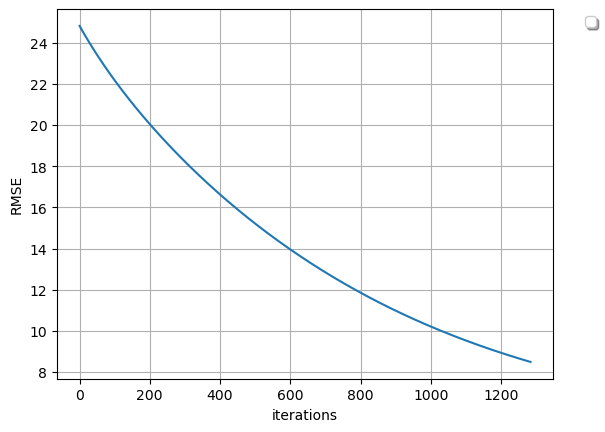


Weights/Theta's:
[16.23709212 -0.65939637  0.29865602 -0.43483153  1.06867399 -0.38021662
  2.80899862 -0.22785823 -0.80791399 -0.02968882 -0.40977397 -1.49558298
  0.77346691 -2.65505195]

Train data:
SSE: 25496.68539900406 
RMSE: 8.48672699133389

Test data:
SSE: 10383.35629902286 
RMSE: 8.265080435109788
Training with learning rate: 0.001, regularization: 0.1
X is Full rank
X is not low rank


  2%|█▊                                                                        | 1250/50000 [00:00<00:01, 29277.57it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


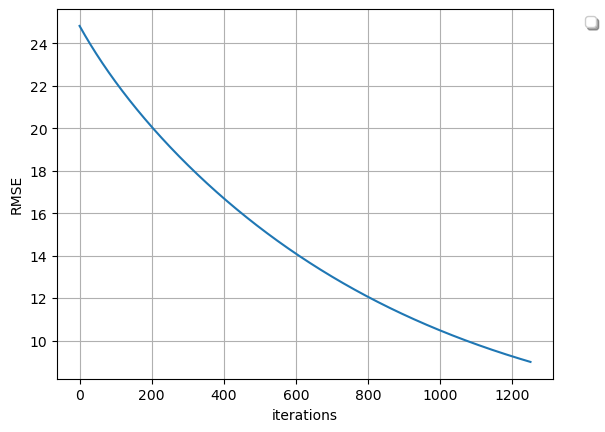


Weights/Theta's:
[15.64300691 -0.65080426  0.30247156 -0.44231814  1.04318827 -0.38000175
  2.7294326  -0.23302916 -0.75530559 -0.05386278 -0.41808297 -1.45991182
  0.75601113 -2.57682929]

Train data:
SSE: 28622.513396186776 
RMSE: 8.991916237173633

Test data:
SSE: 11575.238856816566 
RMSE: 8.726562164787373
Training with learning rate: 0.001, regularization: 0.5
X is Full rank
X is not low rank


  2%|█▍                                                                         | 979/50000 [00:00<00:01, 24803.38it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


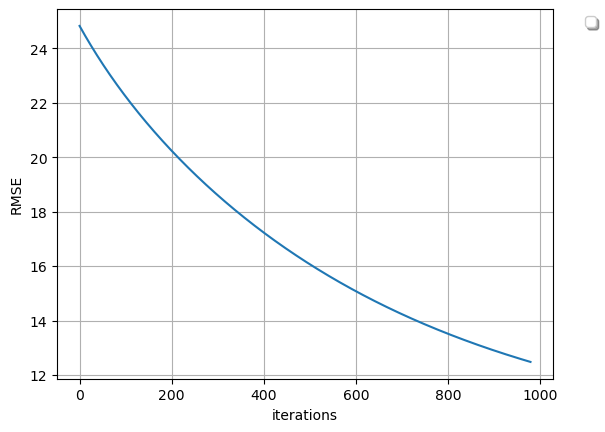


Weights/Theta's:
[11.81982185 -0.59209026  0.32459908 -0.48123935  0.86155679 -0.38389567
  2.19950708 -0.26832138 -0.4295985  -0.19571364 -0.46314697 -1.22007882
  0.64209957 -2.0699712 ]

Train data:
SSE: 55126.71627533784 
RMSE: 12.478989831651779

Test data:
SSE: 21595.02300284037 
RMSE: 11.919417760760329
Training with learning rate: 0.005, regularization: 0.0005
X is Full rank
X is not low rank


  1%|▋                                                                          | 465/50000 [00:00<00:01, 26090.26it/s]

Model stopped learning



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


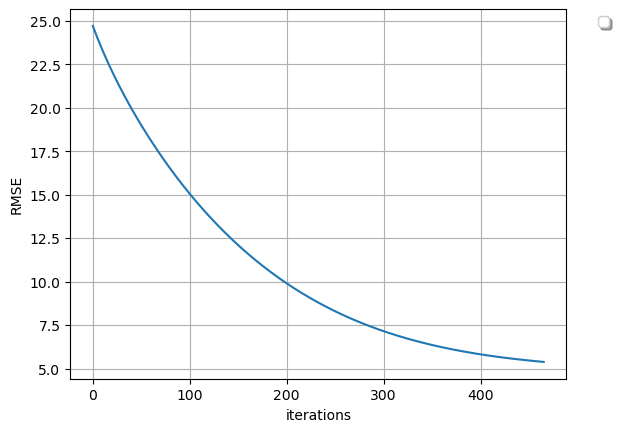


Weights/Theta's:
[20.78174179 -0.72194965  0.27128551 -0.30303877  1.09409409 -0.48033108
  3.25166857 -0.23306614 -1.35224607  0.28326591 -0.29553022 -1.69894154
  0.91041675 -3.26306286]

Train data:
SSE: 10250.288433545287 
RMSE: 5.3810423752199945

Test data:
SSE: 4389.940596827004 
RMSE: 5.374122080583931
Training with learning rate: 0.005, regularization: 0.001
X is Full rank
X is not low rank


  1%|▋                                                                          | 466/50000 [00:00<00:02, 23555.84it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


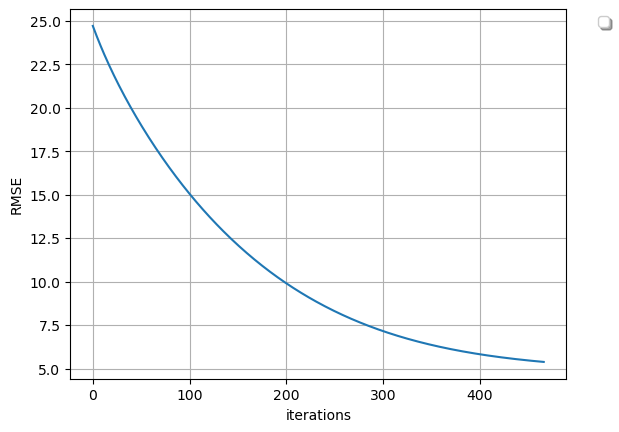


Weights/Theta's:
[20.78506622 -0.72209693  0.27136611 -0.3027089   1.09354479 -0.48093712
  3.25142791 -0.23330113 -1.35327688  0.28396754 -0.29538136 -1.69897504
  0.91058916 -3.26370998]

Train data:
SSE: 10244.38526009215 
RMSE: 5.379492672426433

Test data:
SSE: 4387.3131682942185 
RMSE: 5.372513603797414
Training with learning rate: 0.005, regularization: 0.005
X is Full rank
X is not low rank


  1%|▋                                                                          | 467/50000 [00:00<00:02, 22027.37it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


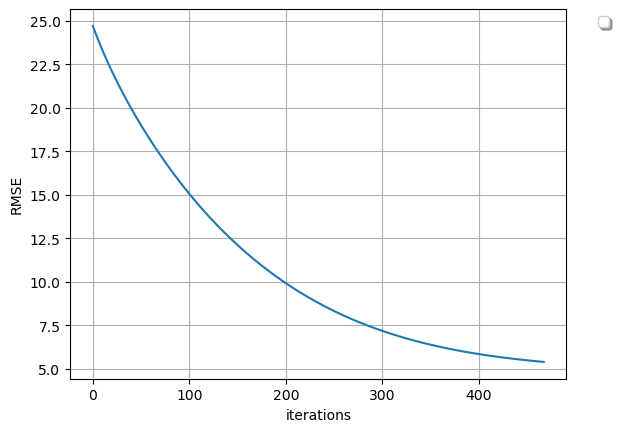


Weights/Theta's:
[20.73383154 -0.72138313  0.27171231 -0.30338671  1.0915063  -0.48089254
  3.24468754 -0.23370698 -1.34873397  0.28183331 -0.29615703 -1.69599684
  0.90908423 -3.25700074]

Train data:
SSE: 10330.369020094251 
RMSE: 5.40202123191836

Test data:
SSE: 4420.387357869235 
RMSE: 5.3927261914040745
Training with learning rate: 0.005, regularization: 0.01
X is Full rank
X is not low rank


  1%|▋                                                                          | 469/50000 [00:00<00:02, 21039.71it/s]

Model stopped learning



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


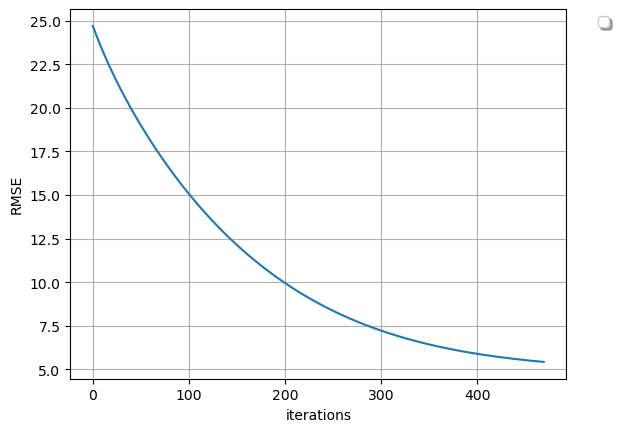


Weights/Theta's:
[20.67787619 -0.72068782  0.27217618 -0.30389094  1.08872175 -0.48134208
  3.23676892 -0.2343646  -1.34438241  0.27996759 -0.29692448 -1.69261542
  0.90750218 -3.24984958]

Train data:
SSE: 10426.219971865357 
RMSE: 5.427024856270709

Test data:
SSE: 4456.937269659903 
RMSE: 5.414975135810573
Training with learning rate: 0.005, regularization: 0.05
X is Full rank
X is not low rank


  1%|▋                                                                          | 479/50000 [00:00<00:02, 22029.78it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


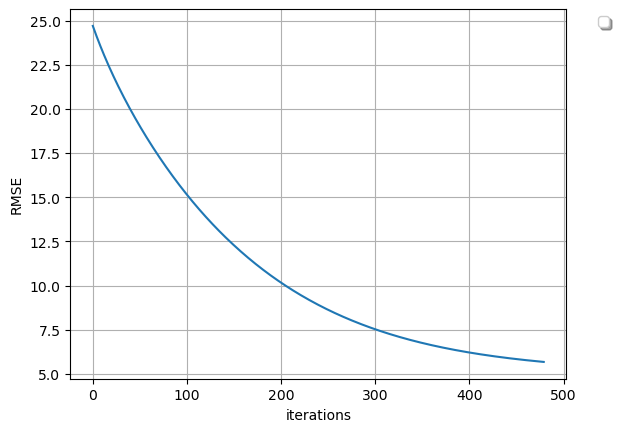


Weights/Theta's:
[20.16783593 -0.713478    0.27551988 -0.31079111  1.06894516 -0.48042605
  3.17013648 -0.23816403 -1.29869807  0.25837435 -0.30468042 -1.66307042
  0.89243498 -3.18286953]

Train data:
SSE: 11411.347910639473 
RMSE: 5.677626799575044

Test data:
SSE: 4834.862651949529 
RMSE: 5.6398853641470925
Training with learning rate: 0.005, regularization: 0.1
X is Full rank
X is not low rank


  1%|▋                                                                          | 483/50000 [00:00<00:01, 28892.82it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


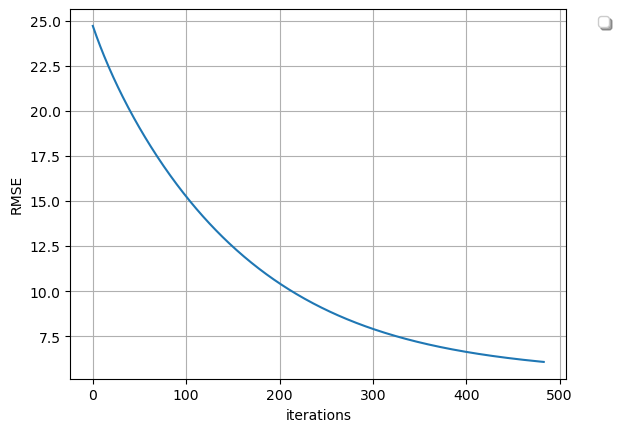


Weights/Theta's:
[19.47352916 -0.70258779  0.27900268 -0.32252628  1.04779691 -0.47368372
  3.08515911 -0.24094362 -1.23006564  0.22418474 -0.31584877 -1.62398131
  0.87116446 -3.08957473]

Train data:
SSE: 13068.401409935868 
RMSE: 6.075885792512944

Test data:
SSE: 5471.658892708101 
RMSE: 5.999812986508797
Training with learning rate: 0.005, regularization: 0.5
X is Full rank
X is not low rank


  1%|▌                                                                          | 402/50000 [00:00<00:02, 24068.03it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


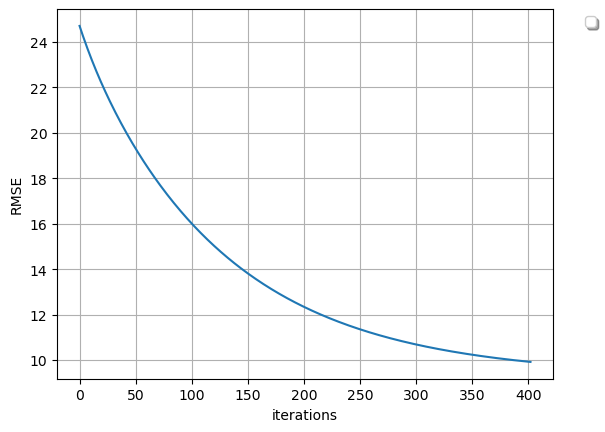


Weights/Theta's:
[14.6054094  -0.61887398  0.29654236 -0.40746418  0.91387497 -0.40534597
  2.50209508 -0.25011625 -0.7317292  -0.02579641 -0.39052344 -1.34823506
  0.71711055 -2.42364314]

Train data:
SSE: 34824.25268274901 
RMSE: 9.918346391864347

Test data:
SSE: 13776.815190101745 
RMSE: 9.520343588345069
Training with learning rate: 0.0001, regularization: 0.0005
X is Full rank
X is not low rank


  0%|                                                                               | 1/50000 [00:00<00:50, 992.97it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


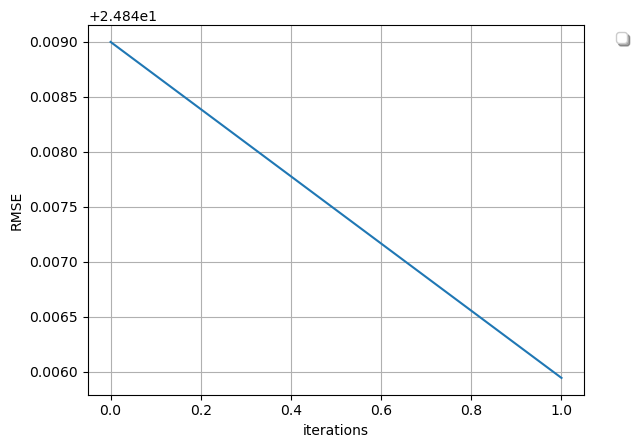


Weights/Theta's:
[ 0.00460293 -0.00071316  0.00061767 -0.00086144  0.00042465 -0.00076228
  0.0013095  -0.00065698  0.00045225 -0.00072108 -0.00084783 -0.00092252
  0.00060922 -0.00140059]

Train data:
SSE: 218531.61848285884 
RMSE: 24.845944461144317

Test data:
SSE: 80948.75980175464 
RMSE: 23.077210192627305
Training with learning rate: 0.0001, regularization: 0.001
X is Full rank
X is not low rank


  0%|                                                                               | 1/50000 [00:00<00:50, 989.92it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


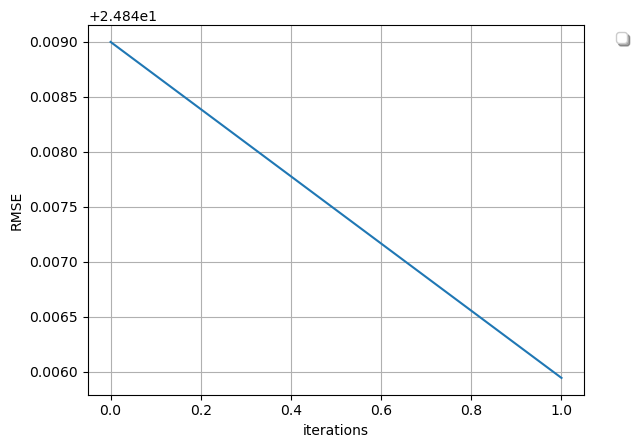


Weights/Theta's:
[ 0.00460293 -0.00071316  0.00061767 -0.00086144  0.00042465 -0.00076228
  0.0013095  -0.00065698  0.00045225 -0.00072108 -0.00084783 -0.00092252
  0.00060922 -0.00140059]

Train data:
SSE: 218531.61848554458 
RMSE: 24.84594446129699

Test data:
SSE: 80948.7598027175 
RMSE: 23.077210192764554
Training with learning rate: 0.0001, regularization: 0.005
X is Full rank
X is not low rank


  0%|                                                                                | 1/50000 [00:00<09:36, 86.68it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


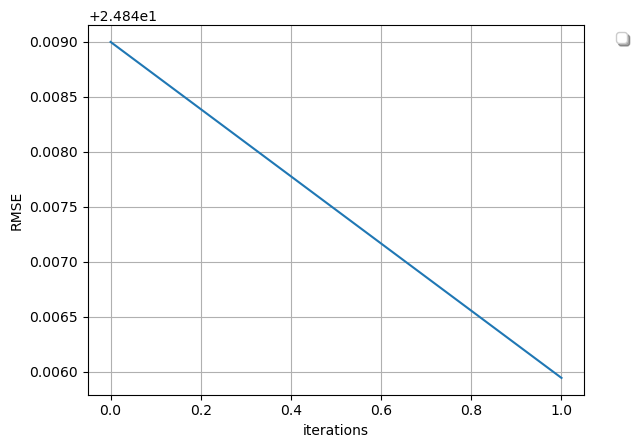


Weights/Theta's:
[ 0.00460293 -0.00071316  0.00061767 -0.00086144  0.00042465 -0.00076228
  0.0013095  -0.00065698  0.00045225 -0.00072108 -0.00084783 -0.00092251
  0.00060922 -0.00140059]

Train data:
SSE: 218531.61850703048 
RMSE: 24.845944462518414

Test data:
SSE: 80948.7598104204 
RMSE: 23.077210193862538
Training with learning rate: 0.0001, regularization: 0.01
X is Full rank
X is not low rank


  0%|                                                                               | 1/50000 [00:00<00:55, 900.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


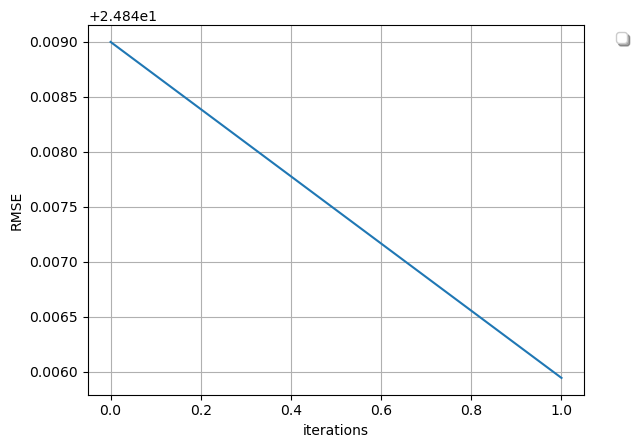


Weights/Theta's:
[ 0.00460293 -0.00071316  0.00061767 -0.00086144  0.00042465 -0.00076228
  0.0013095  -0.00065698  0.00045225 -0.00072108 -0.00084783 -0.00092251
  0.00060922 -0.00140059]

Train data:
SSE: 218531.61853388778 
RMSE: 24.845944464045182

Test data:
SSE: 80948.75982004899 
RMSE: 23.077210195235022
Training with learning rate: 0.0001, regularization: 0.05
X is Full rank
X is not low rank


  0%|                                                                               | 1/50000 [00:00<00:50, 992.50it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


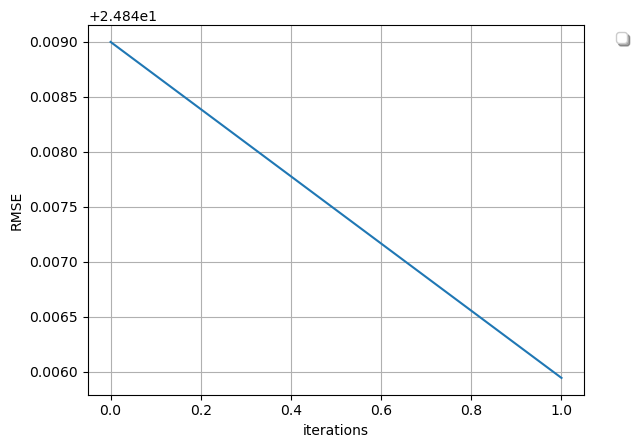


Weights/Theta's:
[ 0.00460292 -0.00071316  0.00061767 -0.00086143  0.00042465 -0.00076227
  0.0013095  -0.00065698  0.00045225 -0.00072108 -0.00084783 -0.00092251
  0.00060922 -0.00140059]

Train data:
SSE: 218531.6187487465 
RMSE: 24.84594447625936

Test data:
SSE: 80948.7598970778 
RMSE: 23.07721020621487
Training with learning rate: 0.0001, regularization: 0.1
X is Full rank
X is not low rank


  0%|                                                                               | 1/50000 [00:00<01:45, 471.91it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


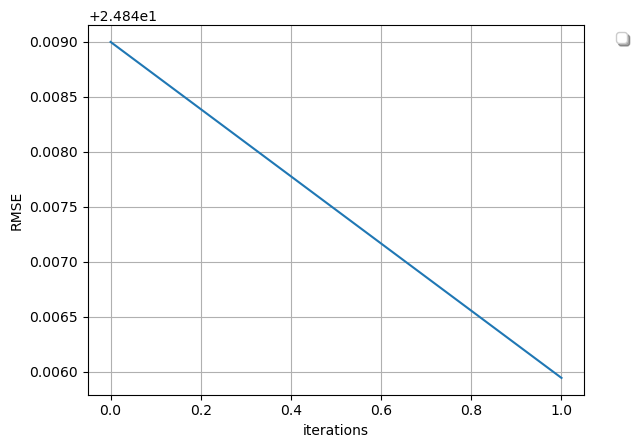


Weights/Theta's:
[ 0.00460291 -0.00071316  0.00061767 -0.00086143  0.00042465 -0.00076227
  0.0013095  -0.00065698  0.00045225 -0.00072108 -0.00084782 -0.00092251
  0.00060922 -0.00140058]

Train data:
SSE: 218531.61901731987 
RMSE: 24.845944491527078

Test data:
SSE: 80948.75999336384 
RMSE: 23.07721021993968
Training with learning rate: 0.0001, regularization: 0.5
X is Full rank
X is not low rank


  0%|                                                                               | 1/50000 [00:00<07:23, 112.79it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model stopped learning


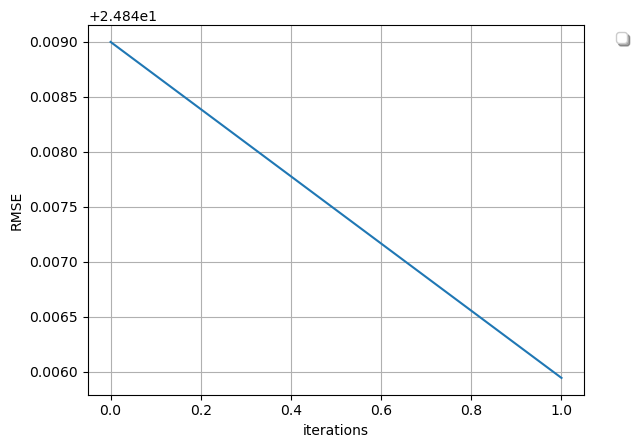


Weights/Theta's:
[ 0.00460282 -0.00071315  0.00061766 -0.00086141  0.00042464 -0.00076226
  0.00130947 -0.00065696  0.00045224 -0.00072107 -0.00084781 -0.00092249
  0.0006092  -0.00140056]

Train data:
SSE: 218531.62116590684 
RMSE: 24.845944613668838

Test data:
SSE: 80948.76076365203 
RMSE: 23.077210329738165


In [47]:
# Initializing hyperparameters
learning_rates = [0.2, 0.1, 0.01, 0.001, 0.005, 0.0001]
regularization_params = [0.0005, 0.001, 0.005, 0.01 , 0.05 , 0.1  , 0.5]

# Initializing lists to store results
results = []

# Initializing lists to store results for plotting
learning_rate_labels = []
regularization_labels = []
train_rmse_values = []
test_rmse_values = []

# Looping through hyperparameters
for lr in learning_rates:
    for reg_param in regularization_params:
        print(f"Training with learning rate: {lr}, regularization: {reg_param}")
        
        # Fit the model and get RMSE for train and test data
        model = LinearRegression(X_h, y_h, learning_rate=lr, epsilon=0.005, max_iteration=50000, reg_lambda=reg_param, gd=True, sgd=False)
        train_rmse, test_rmse = model.fit()

        # Storing results
        results.append((lr, reg_param, train_rmse, test_rmse))
        
        # Storing results for plotting
        learning_rate_labels.append(lr)
        regularization_labels.append(reg_param)
        train_rmse_values.append(train_rmse)
        test_rmse_values.append(test_rmse)

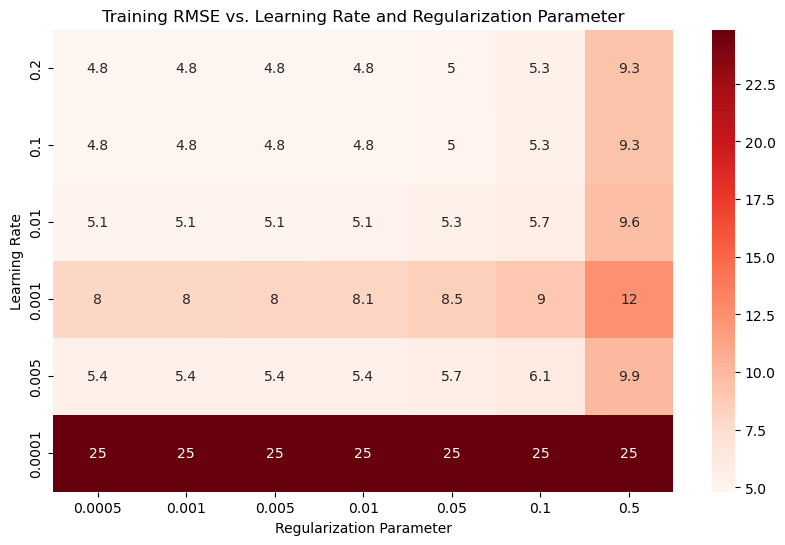

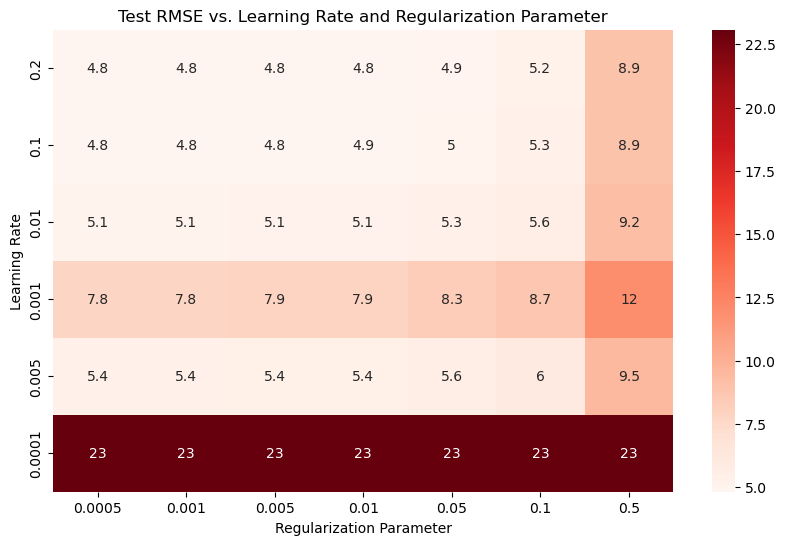

In [50]:
# heatmap for training RMSE
train_rmse_matrix = np.array(train_rmse_values).reshape(len(learning_rates), len(regularization_params))
plt.figure(figsize=(10, 6))
sns.heatmap(train_rmse_matrix, annot=True, xticklabels=regularization_params, yticklabels=learning_rates,cmap='Reds')
plt.xlabel('Regularization Parameter')
plt.ylabel('Learning Rate')
plt.title('Training RMSE vs. Learning Rate and Regularization Parameter')

# heatmap for test RMSE
test_rmse_matrix = np.array(test_rmse_values).reshape(len(learning_rates), len(regularization_params))
plt.figure(figsize=(10, 6))
sns.heatmap(test_rmse_matrix, annot=True, xticklabels=regularization_params, yticklabels=learning_rates,cmap='Reds')
plt.xlabel('Regularization Parameter')
plt.ylabel('Learning Rate')
plt.title('Test RMSE vs. Learning Rate and Regularization Parameter')

plt.show()

- In the heatmap visualization above, I have explored the influence of various combinations of learning rates and regularization parameters on the training, convergence, and ultimate performance of our machine learning model. The heatmap reveals critical insights into how these hyperparameters affect the model's behavior.

- First, we observe that setting an extremely low learning rate, such as 0.0001, leads to a significant drop in model performance, as indicated by a remarkably high Root Mean Square Error (RMSE) of approximately 24. This outcome reflects the challenges of training with very slow learning rates, as the model converges slowly and may get stuck in local optima.

- Conversely, when the regularization parameter is set to a high value, such as 0.5, we notice a decline in model performance, resulting in a lower RMSE of around 9. This highlights the trade-off between regularization strength and model flexibility. Excessive regularization can constrain the model's capacity to fit the data, leading to suboptimal performance.

- Furthermore, a learning rate of 0.001 does not yield an ideal outcome, as it produces an RMSE of about 8. This emphasizes the sensitivity of learning rate selection; values that are too small can hinder convergence speed, impacting both training time and final accuracy.

- A more optimal configuration emerges when we set the learning rate to 0.1 or 0.2, combined with a regularization parameter within the range of [0.0005, 0.001, 0.005, 0.01]. In this scenario, we achieve the best model performance, characterized by a lower RMSE value of 4.8. This exemplifies the importance of a balanced approach to hyperparameter tuning. A moderate learning rate, coupled with appropriate regularization, strikes a harmonious balance between convergence speed and accuracy.

In summary, the analysis underscores the pivotal role played by learning rate and regularization parameters in the machine learning model. Careful consideration and fine-tuning of these hyperparameters are essential, as they impact training dynamics, convergence, and the ultimate success of the model."